#### Given the result of multiple sequence alignment, the following algorithm aims at:
1- Calculate PPM (Position Probability Matrix) based on MSA of P parent peptide sequences - probabilities of all amino acids for all positions along the alignment vector M.

2- Generate C children peptide sequences of M length based on PFM.

3- Calculate the cumulative probability P = 1*p1*p2*...*pM for each peptide sequence P and C. The smallest P value for any P peptide sequence gives the minimal threshold T that identif P-like peptide sequences (P >= T) from all C peptide sequences.

#### Modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
import sklearn
import Bio

#### Loading MSA example

In [2]:
fasta_file = 'C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/avg_len_algn.fas'

In [3]:
from Bio import SeqIO

def split(Alignment):
    Split_df = []
    ids =[]
    for seq in SeqIO.parse(Alignment,'fasta'):
        split_seq = [char for char in seq]
        Split_df.append(split_seq)
        ids.append(seq.id)
    alignment_length = len(Split_df[0])
    col_names = list(map('Col{}'.format, range(1,alignment_length+1)))
    Split_df = pd.DataFrame(Split_df, columns = col_names, index=ids)
    return Split_df

In [4]:
split_fun = split(Alignment=fasta_file)

print(split_fun)

       Col1 Col2 Col3 Col4 Col5 Col6 Col7 Col8 Col9 Col10  ... Col25 Col26  \
P04075    -    -    -    -    -    -    -    -    -     -  ...     N     -   
P03833    -    -    -    -    -    -    -    N    G     R  ...     N     -   
P02485    -    -    -    -    -    -    -    N    G     R  ...     S     -   
P02986    -    -    -    -    -    -    -    N    G     R  ...     K     -   
P02942    -    -    -    -    -    -    -    Q    E     C  ...     L     -   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...   ...   ...   
P06520    -    -    -    -    A    I    G    G    T     C  ...     L     -   
P04193    -    -    -    T    V    I    M    H    N     C  ...     L     -   
P04195    -    -    -    -    G    I    R    G    N     C  ...     F     Y   
P04194    -    -    -    -    G    I    R    G    N     C  ...     F     N   
P04934    -    -    -    -    -    -    -    R    P     C  ...     Y     -   

       Col27 Col28 Col29 Col30 Col31 Col32 Col33 Col34  
P04075

#### Generative Algorithm

1.Calculate Position Frequency Matrix

# Links
- https://en.wikipedia.org/wiki/Position_weight_matrix
- https://www.biostars.org/p/107356/
- https://biopython.org/DIST/docs/api/Bio.motifs.matrix-module.html
- https://stackoverflow.com/questions/57736512/count-the-frequency-of-characters-at-a-position-in-a-string-in-a-pandas-datafram

In [5]:
# Measure Position Frequency Matrix and Position Probability Matrix
pfm = split_fun.apply(pd.Series.value_counts)
ppm = pfm.apply(lambda x: (x/x.sum())).round(2).fillna(0)
print(ppm)

   Col1  Col2  Col3  Col4  Col5  Col6  Col7  Col8  Col9  Col10  ...  Col25  \
-  0.99  0.97  0.97  0.96  0.91  0.86  0.82  0.44  0.07   0.03  ...   0.07   
A  0.00  0.00  0.02  0.01  0.01  0.01  0.01  0.01  0.03   0.00  ...   0.00   
C  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00   0.87  ...   0.00   
D  0.00  0.00  0.00  0.01  0.00  0.01  0.00  0.16  0.05   0.00  ...   0.01   
E  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.04  0.14   0.02  ...   0.01   
F  0.00  0.00  0.00  0.01  0.01  0.01  0.00  0.00  0.00   0.00  ...   0.03   
G  0.00  0.00  0.00  0.00  0.02  0.01  0.01  0.06  0.48   0.00  ...   0.01   
H  0.00  0.00  0.00  0.00  0.00  0.00  0.01  0.01  0.00   0.00  ...   0.03   
I  0.00  0.02  0.00  0.00  0.01  0.03  0.00  0.01  0.00   0.00  ...   0.20   
K  0.00  0.00  0.00  0.00  0.00  0.00  0.01  0.00  0.01   0.00  ...   0.03   
L  0.01  0.00  0.00  0.01  0.00  0.01  0.02  0.03  0.01   0.00  ...   0.21   
M  0.00  0.00  0.00  0.00  0.00  0.01  0.01  0.00  0.00   0.00  

In [6]:
from os import path
figpath = 'C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/charts/'

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns;
fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(ppm, vmin=0, vmax=1, cmap="YlGnBu")
plt.ylabel('Residues')
plt.xlabel('MSA-derived Positions')
plt.title('Position-Specific Probability Matrix', fontsize=14)
plt.suptitle('Cysteine Framework I Conotoxins')
#plt.savefig(figpath+'Cysteine Framework I Heatmap - Position-Specific Probability Matrix (346 toxins).pdf')
#plt.close()
plt.show()

2.Generate children (C) peptide sequences of M length

- https://stackoverflow.com/questions/27007070/generate-n-random-string-of-length-k-using-probability-table

In [8]:
# Generate a dictionary where keys are the dataframe columns (positions) and values are the rows indexes (residues)
ppm_dict = ppm.to_dict()

# Filter all positions(k)/residues(v) pairs where values are equal to zero.
def remove_empty_from_dict(d):
    if type(d) is dict:
        return dict((k, remove_empty_from_dict(v)) for k, v in d.items() if v and remove_empty_from_dict(v))
    elif type(d) is list:
        return [remove_empty_from_dict(v) for v in d if v and remove_empty_from_dict(v)]
    else:
        return d

cleaned_ppm_dict = remove_empty_from_dict(ppm_dict)
cleaned_ppm_dict

{'Col1': {'-': 0.99, 'L': 0.01},
 'Col2': {'-': 0.97, 'I': 0.02, 'T': 0.01},
 'Col3': {'-': 0.97, 'A': 0.02, 'S': 0.01},
 'Col4': {'-': 0.96, 'A': 0.01, 'D': 0.01, 'F': 0.01, 'L': 0.01, 'P': 0.01},
 'Col5': {'-': 0.91,
  'A': 0.01,
  'F': 0.01,
  'G': 0.02,
  'I': 0.01,
  'S': 0.01,
  'T': 0.02},
 'Col6': {'-': 0.86,
  'A': 0.01,
  'D': 0.01,
  'F': 0.01,
  'G': 0.01,
  'I': 0.03,
  'L': 0.01,
  'M': 0.01,
  'Q': 0.01,
  'T': 0.01,
  'V': 0.02},
 'Col7': {'-': 0.82,
  'A': 0.01,
  'G': 0.01,
  'H': 0.01,
  'K': 0.01,
  'L': 0.02,
  'M': 0.01,
  'N': 0.01,
  'R': 0.05,
  'S': 0.01,
  'T': 0.02,
  'W': 0.02,
  'Y': 0.01},
 'Col8': {'-': 0.44,
  'A': 0.01,
  'D': 0.16,
  'E': 0.04,
  'G': 0.06,
  'H': 0.01,
  'I': 0.01,
  'L': 0.03,
  'N': 0.07,
  'P': 0.05,
  'Q': 0.05,
  'R': 0.04,
  'S': 0.01,
  'T': 0.01},
 'Col9': {'-': 0.07,
  'A': 0.03,
  'D': 0.05,
  'E': 0.14,
  'G': 0.48,
  'K': 0.01,
  'L': 0.01,
  'N': 0.02,
  'P': 0.07,
  'Q': 0.01,
  'R': 0.01,
  'S': 0.02,
  'T': 0.03,
  'V

In [9]:
positions = ppm.columns
list(cleaned_ppm_dict[positions[0]].keys())

['-', 'L']

In [10]:
import random
pick_list = []
seq_list = []
k=0
K=34


while k < K:
    pick_list = list(cleaned_ppm_dict[positions[k]].keys())
    #print(pick_list)
    sub_seq = "".join(random.choice(pick_list))
    #print(sub_seq)
    seq_list.append(sub_seq)
    k += 1
#print(seq_list)
print(''.join(seq_list))

L----QAHVECPTLL-KCFF--TSG-CRWRSYRP


In [11]:
def seq_prob(fprob_table, K=34):
    pick_list = []
    seq_list = []
    k=0

    while k < K:
        pick_list = list(cleaned_ppm_dict[positions[k]].keys())
        #print(pick_list)
        sub_seq = "".join(random.choice(pick_list))
        #print(sub_seq)
        seq_list.append(sub_seq)
        k += 1
    #print(seq_list)
    seq = ''.join(seq_list)
    return seq

In [12]:
N=100
sequences = []
for _ in range(N):
    seq = seq_prob(cleaned_ppm_dict)
    sequences.append(seq)

sequences

['--AATMSAEECDIDA--C-YRNSSEYCSGSSY--',
 '-IAAGGGNDYCSTHE-QC-NTVAKE-CG-TY-RP',
 'L--PIITG-ECNRFK-GCGTTWMVEYCTQI-Y-P',
 '-I--TV-GYYCEISL-QCSE-MSVWYCG-RS--P',
 'LISDS-ARDYCV-PL-LCQTDYLKY-CRQIV---',
 '--ALIMKHTRCDTLE-FCYTSR-N--CLRMG-RP',
 '-ISAITNTVYCWAHE-LCGQEFIHWYCYATSYR-',
 '-ISAITSPAYCY-NR-MCQFKFAHG-C-WRY--P',
 '-ISDGVYQACCNALS-YC-RLNNDNYC-KISYR-',
 '-TSATLLDTRCDAPP-DCAVYVYGH-CYGDI---',
 '--SFAQWQ-ECYTFS-VCSFQSTMV-CLATY--P',
 '--S-SGWSNRCYTPL--CAYNIMLD-CLGGG-RP',
 'LIS-FAGSGYCDAYR-KCIKL-ASFYCDQID---',
 'LT-LTG-RYYCHRRH-DCKAINKHS-CT-MVY--',
 '-ISAAVWNKECDAIP-YCPLRNPQG-CVA-S-RP',
 '-TSFTI-QRRCNAVE-DCAS-FQDM-CNTDIYRP',
 '--SDTDM-SCCNARS-DCRHEWPL--CSRRSYR-',
 'L-ALGTWIVYCDAFA-FCVMS--LL-CLQIVY--',
 'LI-FAFKNPYCYIEE-FCQNN-MNGYCYT-SY-P',
 'L-ADG-YPPRCEIPH-MCYV-YTMN-CVQ-D-RP',
 'LISFFARNKYCNRIA-QCHALSNL-YCVTGS-RP',
 '--AP-IATQCCGTFL-FCMRKM-F-YCLGIVY--',
 'LISPGFMEVRCDANG-LCVGN-KKK-CTRGG-RP',
 'L-AP-QKLGRCYREK-QCPSAHRFE-CVCISY-P',
 'LTSFIGHNRYCDING-LCQRIMLGRYCNAMVY--',
 '-ISPSD-PRECMRHG-KCHLD-R

3. Objective function: The cumulative frequency F for any peptide sequence(s)

In [13]:
seq ='-------NGRCC-HP-ACG--KHFN-C-------'

In [14]:
cumprob = 0
cumdist = []
pos=0 #position in sequence and dataframe column
K=5
while pos < 34:
    #print(seq[pos])
    for res in range(len(ppm.index)): # residue
        if seq[pos] == ppm.index[res]:
            #print(res, pos, ppm.iloc[res][pos])
            cumprob += ppm.iloc[res][pos]
            cumdist.append(ppm.iloc[res][pos])
            
    pos +=1
print(seq, round(cumprob, 3))
print(cumdist)

-------NGRCC-HP-ACG--KHFN-C------- 21.88
[0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.07, 0.48, 0.07, 1.0, 0.14, 0.95, 0.29, 0.82, 1.0, 0.41, 1.0, 0.15, 0.29, 0.28, 0.09, 0.06, 0.08, 0.04, 0.99, 1.0, 0.58, 0.83, 0.88, 0.93, 0.99, 0.99, 0.99]


In [15]:
def cumulative_probability(seq, K=34):
    cumprob = 0
    cumdist = []
    pos=0 #position in sequence and dataframe column
    while pos < K:
        #print(seq[pos])
        for res in range(len(ppm.index)): # residue
            if seq[pos] == ppm.index[res]:
                #print(res, pos, ppm.iloc[res][pos])
                cumprob += ppm.iloc[res][pos]
                cumdist.append(ppm.iloc[res][pos])
            
        pos +=1
    return(round(cumprob, 3))

In [16]:
def cumulative_distribution(seq, K=34):
    cumprob = 0
    cumdist = []
    pos=0 #position in sequence and dataframe column
    while pos < K:
        for res in range(len(ppm.index)): # residue
            if seq[pos] == ppm.index[res]:
                cumdist.append(ppm.iloc[res][pos])
            
        pos +=1
    return(cumdist)

def product_probability(seq, K=34):
    prodprob = 0
    cumdist = []
    pos=0 #position in sequence and dataframe column
    while pos < K:
        #print(seq[pos])
        for res in range(len(ppm.index)): # residue
            if seq[pos] == ppm.index[res]:
                #print(res, pos, ppm.iloc[res][pos])
                prodprob *= ppm.iloc[res][pos]
                cumdist.append(ppm.iloc[res][pos])
            
        pos +=1
    return(round(prodprob, 20))

In [17]:
s = '-------NGRCC-HP-ACG--KHFN-C-------'
cumulative_probability(s)

21.88

product_probability(s)

In [18]:
cumulative_distribution(s)

[0.99,
 0.97,
 0.97,
 0.96,
 0.91,
 0.86,
 0.82,
 0.07,
 0.48,
 0.07,
 1.0,
 0.14,
 0.95,
 0.29,
 0.82,
 1.0,
 0.41,
 1.0,
 0.15,
 0.29,
 0.28,
 0.09,
 0.06,
 0.08,
 0.04,
 0.99,
 1.0,
 0.58,
 0.83,
 0.88,
 0.93,
 0.99,
 0.99,
 0.99]

In [19]:
sequences_2 =[]
ids = []

for seq in SeqIO.parse(fasta_file, 'fasta'):
    sequences_2.append(str(seq.seq))
    ids.append(seq.id)

In [20]:
cumprobs = []
for s in sequences_2:
    cumprobs.append(cumulative_probability(s))

real_conotoxins_df = pd.DataFrame(list(zip(sequences_2, cumprobs)), columns =['Sequence', 'Cumulative_Probability'], index=ids)
real_conotoxins_df

Sequence  Cumulative_Probability
P04075  ----------CC-HP-SCG--RKYN-C-------                   21.42
P03833  -------NGRCC-HP-ACG--KHFN-C-------                   21.88
P02485  -------NGRCC-HP-ACG--KHFS-C-------                   21.93
P02986  -------NGRCC-HP-ACGG-KYVK-C-------                   21.60
P02942  -------QECCS-YP-ACNLDHPEL-C-------                   22.83
...                                    ...                     ...
P06520  ----AIGGTCCP-IP-SCASTFPRL-C-------                   19.08
P04193  ---TVIMHNCCT-RS-FCKRIYPDL-CS------                   16.67
P04195  ----GIRGNCCM-FH-TCPIDYSRFYCP------                   15.89
P04194  ----GIRGNCCM-FH-TCPIDYSRFNCP------                   15.88
P04934  -------RPCCS-LR-WCS----NY-CRCGI---                   18.07

[346 rows x 2 columns]

In [21]:
cumdists = []
for s in sequences_2:
    cumdists.append(cumulative_distribution(s))

real_conotoxins_df2 = pd.DataFrame(list(zip(sequences_2, cumdists)), columns=['Sequence', 'Cumulative_Distribution'], index=ids)
real_conotoxins_df2

Sequence  \
P04075  ----------CC-HP-SCG--RKYN-C-------   
P03833  -------NGRCC-HP-ACG--KHFN-C-------   
P02485  -------NGRCC-HP-ACG--KHFS-C-------   
P02986  -------NGRCC-HP-ACGG-KYVK-C-------   
P02942  -------QECCS-YP-ACNLDHPEL-C-------   
...                                    ...   
P06520  ----AIGGTCCP-IP-SCASTFPRL-C-------   
P04193  ---TVIMHNCCT-RS-FCKRIYPDL-CS------   
P04195  ----GIRGNCCM-FH-TCPIDYSRFYCP------   
P04194  ----GIRGNCCM-FH-TCPIDYSRFNCP------   
P04934  -------RPCCS-LR-WCS----NY-CRCGI---   

                                  Cumulative_Distribution  
P04075  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.4...  
P03833  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.0...  
P02485  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.0...  
P02986  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.0...  
P02942  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.0...  
...                                                   ...  
P06520  [0.99, 0.97, 0.97, 0.96, 0.01, 0.03, 0.01, 0.0...  
P04193  [0.99, 0.97, 0.97, 0.0, 0.0, 0.03, 0.01, 0.01,...  
P04195  [0.99, 0.97, 0.97, 0.96, 0.02, 0.03, 0.05, 0.0...  
P04194  [0.99, 0.97, 0.97, 0.96, 0.02, 0.03, 0.05, 0.0...  
P04934  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.0...  

[346 rows x 2 columns]

prodprobs = []
for s in sequences_2:
    prodprobs.append(product_probability(s))

real_conotoxins_df3 = pd.DataFrame(list(zip(sequences_2, prodprobs)), columns =['Sequence', 'Product_Probability'], index=ids)
real_conotoxins_df3

In [22]:
filepath = 'C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/'

In [23]:
#Convert Cumulative Distribution lists into dataframe and save it as csv.
real_conotoxins_freqs_df = pd.DataFrame(real_conotoxins_df2['Cumulative_Distribution'].values.tolist(), index=real_conotoxins_df2.index, columns=ppm.columns)
real_conotoxins_freqs_df.to_csv(filepath + 'real_conotoxins_freqs_df.csv')

In [24]:
#Generating new sequences
N=100 # 100 first
ids2 = ['conotoxin1.{}'.format(i) for i in range(1, N+1)]
sequences = []
for _ in range(N):
    s1 = seq_prob(cleaned_ppm_dict)
    sequences.append(s1)

# Calculating their cumulative probabilities
cumprobs = []
cumdists = []
for s2 in sequences:
    cumprobs.append(cumulative_probability(s2))
    cumdists.append(cumulative_distribution(s2))

first_trial_df = pd.DataFrame(list(zip(sequences, cumdists, cumprobs)), columns =['Sequence', 'Cumulative Distribution', 'Cumulative Probability'], index=ids2)
first_trial_df

Sequence  \
conotoxin1.1    -TSAILTRACCMTVR-ACF-QMR-GYCRTM--RP   
conotoxin1.2    LIALGMNELCCWRSR-RCELNRTKG-CDWSI-RP   
conotoxin1.3    -ISFSDK-LRCMRNH-ACKSHVHRHYCYWD----   
conotoxin1.4    L-APFMGIVRCW-IH-KCYTQIN--YCKRRG-RP   
conotoxin1.5    LISDFDNDY-CFADY-ACYEIMAMNYC-RDG-RP   
...                                            ...   
conotoxin1.96   -IA-IAADAYCNTHK-GCHLQ-TLL-CN-D----   
conotoxin1.97   LI-FFDSNRCCCRPL-MCNYLYKMY-CGEIDYRP   
conotoxin1.98   L-APFGSG-YCETHA-WCSVAVPYD-C-T-Y-R-   
conotoxin1.99   L--AAVSAERCHRIY-FCGVLWKSF-CGQDD--P   
conotoxin1.100  LI-DAAREK-CNINK-QCNNINLGRYCNWDD---   

                                          Cumulative Distribution  \
conotoxin1.1    [0.99, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.0...   
conotoxin1.2    [0.01, 0.02, 0.02, 0.01, 0.02, 0.01, 0.01, 0.0...   
conotoxin1.3    [0.99, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.4...   
conotoxin1.4    [0.01, 0.97, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0...   
conotoxin1.5    [0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1...   
...                                                           ...   
conotoxin1.96   [0.99, 0.02, 0.02, 0.96, 0.01, 0.01, 0.01, 0.1...   
conotoxin1.97   [0.01, 0.02, 0.97, 0.01, 0.01, 0.01, 0.01, 0.0...   
conotoxin1.98   [0.01, 0.97, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0...   
conotoxin1.99   [0.01, 0.97, 0.97, 0.01, 0.01, 0.02, 0.01, 0.0...   
conotoxin1.100  [0.01, 0.02, 0.97, 0.01, 0.01, 0.01, 0.05, 0.0...   

                Cumulative Probability  
conotoxin1.1                      8.96  
conotoxin1.2                      7.64  
conotoxin1.3                     10.43  
conotoxin1.4                      7.51  
conotoxin1.5                      6.68  
...                                ...  
conotoxin1.96                    12.81  
conotoxin1.97                     7.72  
conotoxin1.98                    10.89  
conotoxin1.99                     9.90  
conotoxin1.100                    8.96  

[100 rows x 3 columns]

In [25]:
#Generating new sequences
N=500 # 500 sequences
ids2 = ['conotoxin1.{}'.format(i) for i in range(101, N+101)]
sequences = []
for _ in range(N):
    s1 = seq_prob(cleaned_ppm_dict)
    sequences.append(s1)

# Calculating their cumulative probabilities
cumprobs = []
cumdists = []
for s2 in sequences:
    cumprobs.append(cumulative_probability(s2))
    cumdists.append(cumulative_distribution(s2))

second_trial_df = pd.DataFrame(list(zip(sequences, cumdists, cumprobs)), columns =['Sequence', 'Cumulative Distribution', 'Cumulative Probability'], index=ids2)
second_trial_df

Sequence  \
conotoxin1.101  -IA-TLYIS-CPTDP-GCNL-WGPYYCSCTGY--   
conotoxin1.102  LIS-SAM-DCCCTRG-WCS-IPLAE-C--RYYRP   
conotoxin1.103  --ALGFTAS-CEREA-GCIARM-S-YCNKDY-R-   
conotoxin1.104  -T-LFGRQARCMTRR-AC-YIIYSG-CPRRD--P   
conotoxin1.105  LI-FSMTRARCWANS-SCSYSPMLW-C-RIVYR-   
...                                            ...   
conotoxin1.596  LTAF-VWGAECKRVG--CKMRWQAI-CNW-Y--P   
conotoxin1.597  ----IIR--ECRTSS-GCMFQ-GASYCPGR-YR-   
conotoxin1.598  -T-F-VM-GRCFTSY-VCKHHIGY--CAQTSYR-   
conotoxin1.599  -ISPSIYADRCWRNA-RCMYHSNPRYCNTMDYR-   
conotoxin1.600  --AFT-RPRECV-EL-KCWFNPGNYYCI-MGY--   

                                          Cumulative Distribution  \
conotoxin1.101  [0.99, 0.02, 0.02, 0.96, 0.02, 0.01, 0.01, 0.0...   
conotoxin1.102  [0.01, 0.02, 0.01, 0.96, 0.01, 0.01, 0.01, 0.4...   
conotoxin1.103  [0.99, 0.97, 0.02, 0.01, 0.02, 0.01, 0.02, 0.0...   
conotoxin1.104  [0.99, 0.01, 0.97, 0.01, 0.01, 0.01, 0.05, 0.0...   
conotoxin1.105  [0.01, 0.02, 0.97, 0.01, 0.01, 0.01, 0.02, 0.0...   
...                                                           ...   
conotoxin1.596  [0.01, 0.01, 0.02, 0.01, 0.91, 0.02, 0.02, 0.0...   
conotoxin1.597  [0.99, 0.97, 0.97, 0.96, 0.01, 0.03, 0.05, 0.4...   
conotoxin1.598  [0.99, 0.01, 0.97, 0.01, 0.91, 0.02, 0.01, 0.4...   
conotoxin1.599  [0.99, 0.02, 0.01, 0.01, 0.01, 0.03, 0.01, 0.0...   
conotoxin1.600  [0.99, 0.97, 0.02, 0.01, 0.02, 0.86, 0.05, 0.0...   

                Cumulative Probability  
conotoxin1.101                    9.76  
conotoxin1.102                    9.64  
conotoxin1.103                    8.55  
conotoxin1.104                    9.93  
conotoxin1.105                    8.44  
...                                ...  
conotoxin1.596                    9.53  
conotoxin1.597                   10.98  
conotoxin1.598                   10.32  
conotoxin1.599                    6.79  
conotoxin1.600                   11.35  

[500 rows x 3 columns]

In [26]:
#Generating new sequences
N=1000 # 1000 new sequences
ids2 = ['conotoxin1.{}'.format(i) for i in range(601, N+601)]
sequences = []
for _ in range(N):
    s1 = seq_prob(cleaned_ppm_dict)
    sequences.append(s1)

# Calculating their cumulative probabilities
cumprobs = []
cumdists = []
for s2 in sequences:
    cumprobs.append(cumulative_probability(s2))
    cumdists.append(cumulative_distribution(s2))

third_trial_df = pd.DataFrame(list(zip(sequences, cumdists, cumprobs)), columns =['Sequence', 'Cumulative Distribution', 'Cumulative Probability'], index=ids2)
third_trial_df

Sequence  \
conotoxin1.601   -ISL-FLI-CCPTDT-QCFISKQMI-CN-RIY-P   
conotoxin1.602   LT-FAARTQRCCIEA-SCWMKLADSYCYKDDY-P   
conotoxin1.603   L-SAIDHNDRCCRRS-RCITYYYGY-CTCSDYR-   
conotoxin1.604   -T--IIRSSYCRRHY-ACQMKPAGFYCPEDG-RP   
conotoxin1.605   -ISFAML-A-CGIFG-YC-MKWP-IYCL-MS---   
...                                             ...   
conotoxin1.1596  -T-PFIA-VECGTVH-KCPGTMMR--CSTDIY-P   
conotoxin1.1597  LI-D-FSATCCW-VE-YCQHYHGFHYCVTTSYRP   
conotoxin1.1598  L---G-N-DECK-DE-TCNRQPQLMYCNKTI--P   
conotoxin1.1599  -ISPALTTNCCR-LG-FCR-NIAPRYC-GD-YRP   
conotoxin1.1600  -IAFTVHGKCCKAVS-DCQTMLRGD-C-WGIY--   

                                           Cumulative Distribution  \
conotoxin1.601   [0.99, 0.02, 0.01, 0.01, 0.91, 0.01, 0.02, 0.0...   
conotoxin1.602   [0.01, 0.01, 0.97, 0.01, 0.01, 0.01, 0.05, 0.0...   
conotoxin1.603   [0.01, 0.97, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...   
conotoxin1.604   [0.99, 0.01, 0.97, 0.96, 0.01, 0.03, 0.05, 0.0...   
conotoxin1.605   [0.99, 0.02, 0.01, 0.01, 0.01, 0.01, 0.02, 0.4...   
...                                                            ...   
conotoxin1.1596  [0.99, 0.01, 0.97, 0.01, 0.01, 0.03, 0.01, 0.4...   
conotoxin1.1597  [0.01, 0.02, 0.97, 0.01, 0.91, 0.01, 0.01, 0.0...   
conotoxin1.1598  [0.01, 0.97, 0.97, 0.96, 0.02, 0.86, 0.01, 0.4...   
conotoxin1.1599  [0.99, 0.02, 0.01, 0.01, 0.01, 0.01, 0.02, 0.0...   
conotoxin1.1600  [0.99, 0.02, 0.02, 0.01, 0.02, 0.02, 0.01, 0.0...   

                 Cumulative Probability  
conotoxin1.601                    10.56  
conotoxin1.602                     6.94  
conotoxin1.603                     7.87  
conotoxin1.604                     9.08  
conotoxin1.605                    10.44  
...                                 ...  
conotoxin1.1596                    8.98  
conotoxin1.1597                    8.38  
conotoxin1.1598                   11.77  
conotoxin1.1599                    9.46  
conotoxin1.1600                    9.84  

[1000 rows x 3 columns]

In [27]:
# Any duplicated sequence within trials?
def Repeat(x): 
    _size = len(x) 
    repeated = [] 
    for i in range(_size): 
        k = i + 1
        for j in range(k, _size): 
            if x[i] == x[j] and x[i] not in repeated: 
                repeated.append(x[i]) 
    return repeated 

print(Repeat(first_trial_df.Sequence)) # None
print(Repeat(second_trial_df.Sequence)) # None
print(Repeat(third_trial_df.Sequence)) # None

[]
[]
[]


In [28]:
# Any duplicated sequence between trials?
def common_member(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    if (a_set & b_set): 
        print(a_set & b_set) 
    else: 
        print("No common elements")
        
common_member(first_trial_df.Sequence, second_trial_df.Sequence) # None
common_member(first_trial_df.Sequence, third_trial_df.Sequence) # None
common_member(second_trial_df.Sequence, third_trial_df.Sequence) # None

No common elements
No common elements
No common elements


4.Plot frequency distribution for P and C1 peptide sequences (1st generation)

In [29]:
import seaborn as sns

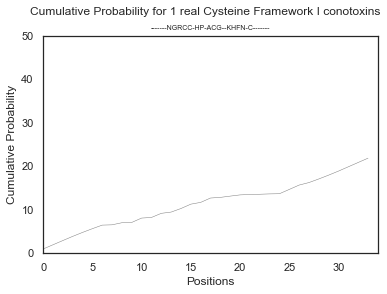

In [30]:
# Plot cumulative probability (34 positions) for each dataset to see which positions take the smallest/largest probabilities
sns.set()
sns.set_style("white")

x = real_conotoxins_df2['Cumulative_Distribution'][1]
plt.plot(pd.Series(x).cumsum(), color='grey', linewidth=0.5)
plt.xlim(0,34)
plt.ylim(0,50)

plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.suptitle('Cumulative Probability for 1 real Cysteine Framework I conotoxins', fontsize=12)
plt.title(real_conotoxins_df2['Sequence'][1], fontsize=7)
#plt.savefig('C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/charts/Cumulative Probability for 1 real Cysteine Framework I cono-toxin.pdf')
#plt.close()
plt.show()

In [31]:
real_conotoxins_df2['Sequence'][1]

'-------NGRCC-HP-ACG--KHFN-C-------'

In [32]:
real_conotoxins_df['Cumulative_Probability'][1]

21.88

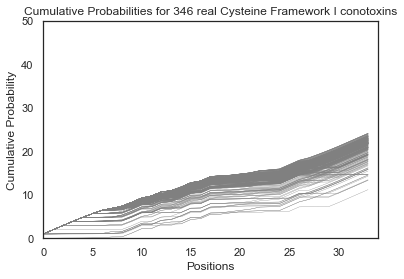

In [33]:
sns.set()
sns.set_style("white")
for i in range(346):
    x = real_conotoxins_df2['Cumulative_Distribution'][i]
    plt.plot(pd.Series(x).cumsum(), color='grey', linewidth=0.3)
    plt.xlim(0,34)
    plt.ylim(0,50)

#ax = plt.axes()
#ax.set_axis_bgcolor(color='white')
plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 346 real Cysteine Framework I conotoxins')
#plt.savefig(figpath+"Cumulative Probabilities for 346 real Cysteine Framework I conotoxins.pdf")
#plt.close()
plt.show()

atx.shape

sns.set()
sns.set_style("white")
for i in range(43):
    x1 = atx['Cumulative_Distribution'][i]
    plt.plot(pd.Series(x1).cumsum(), color='purple', linewidth=0.3)
    plt.xlim(0,77)
    plt.ylim(0,50)

#ax = plt.axes()
#ax.set_axis_bgcolor(color='white')
plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 43 real ATx beta-toxins')
#plt.savefig(path.join(figpath, "Cumulative Probabilities for 43 real ATx beta-toxins.pdf"))
#plt.close()
plt.show()

sns.set()
sns.set_style("white")
for i in range(50):
    x2 = mtx['Cumulative_Distribution'][i]
    plt.plot(pd.Series(x2).cumsum(), color='orange', linewidth=0.3)
    plt.xlim(0,77)
    plt.ylim(0,50)

#ax = plt.axes()
#ax.set_axis_bgcolor(color='white')
plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 50 real MTx beta-toxins')
#plt.savefig(path.join(figpath, "Cumulative Probabilities for 50 real MTx beta-toxins.pdf"))
#plt.close()
plt.show()

sns.set()
sns.set_style("white")
for i in range(43):
    x1 = atx['Cumulative_Distribution'][i]
    plt.plot(pd.Series(x1).cumsum(), color='purple', linewidth=0.3)
    plt.xlim(0,77)
    plt.ylim(0,50)

for i in range(50):
    x2 = mtx['Cumulative_Distribution'][i]
    plt.plot(pd.Series(x2).cumsum(), color='orange', linewidth=0.3)
    plt.xlim(0,77)
    plt.ylim(0,50)

#ax = plt.axes()
#ax.set_axis_bgcolor(color='white')
plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 93 real beta-toxins (MTx + ATx)')
#plt.savefig(path.join(figpath, "Cumulative Probabilities for 93 real beta-toxins (MTx + ATx).pdf"))
#plt.close()
plt.show()

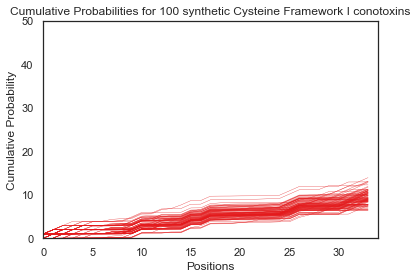

In [34]:
sns.set()
sns.set_style("white")
for i in range(100):
    x = first_trial_df['Cumulative Distribution'][i]
    plt.plot(pd.Series(x).cumsum(), color='#e41a1c', linewidth=0.3)
    plt.xlim(0,34)
    plt.ylim(0,50)

#ax = plt.axes()
#ax.set_axis_bgcolor(color='white')
plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 100 synthetic Cysteine Framework I conotoxins')
#plt.savefig(figpath+"Cumulative Probabilities for 100 synthetic Cysteine Framework I conotoxins.pdf")
#plt.close()
plt.show()

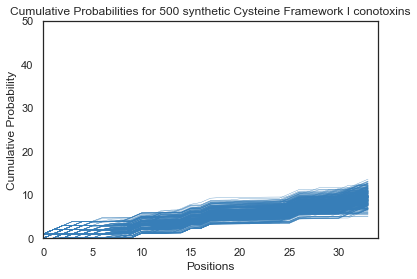

In [35]:
sns.set()
sns.set_style("white")
for i in range(500):
    x = second_trial_df['Cumulative Distribution'][i]
    plt.plot(pd.Series(x).cumsum(), color='#377eb8', linewidth=0.3)
    plt.xlim(0,34)
    plt.ylim(0,50)

#ax = plt.axes()
#ax.set_axis_bgcolor(color='white')
plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 500 synthetic Cysteine Framework I conotoxins')
#plt.savefig(filepath+"Cumulative Probabilities for 500 synthetic Cysteine Framework I conotoxins.pdf")
#plt.close()
plt.show()

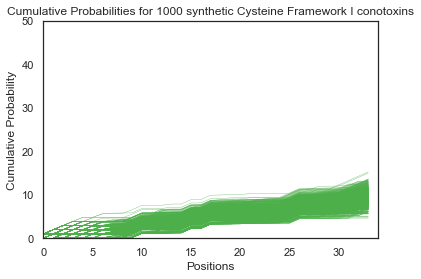

In [36]:
sns.set()
sns.set_style("white")
for i in range(1000):
    x = third_trial_df['Cumulative Distribution'][i]
    plt.plot(pd.Series(x).cumsum(), color='#4daf4a', linewidth=0.3)
    plt.xlim(0,34)
    plt.ylim(0,50)

#ax = plt.axes()
#ax.set_axis_bgcolor(color='white')
plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins')
#plt.savefig(figpath+"Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins.pdf")
#plt.close()
plt.show()

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


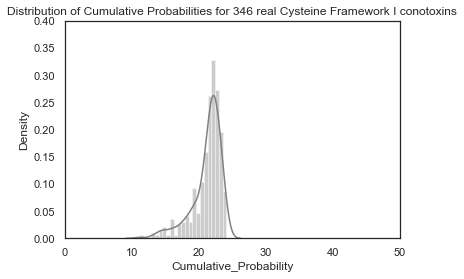

In [37]:
# Plot distributions of cumulative probabilities (34 positions) for each dataset to see which positions take the smallest/largest probabilities
sns.distplot(real_conotoxins_df['Cumulative_Probability'], color='grey')
plt.xlim(0,50)
plt.ylim(0,0.4)
plt.title('Distribution of Cumulative Probabilities for 346 real Cysteine Framework I conotoxins')
#plt.savefig(figpath+"Distribution of Cumulative Probabilities for 346 real Cysteine Framework I conotoxins.pdf")
#plt.close()
plt.show()

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


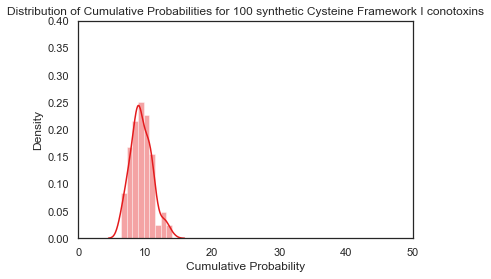

In [38]:
sns.distplot(first_trial_df['Cumulative Probability'], color='#e41a1c')
plt.xlim(0,50)
plt.ylim(0,0.4)
plt.title('Distribution of Cumulative Probabilities for 100 synthetic Cysteine Framework I conotoxins')
#plt.savefig(figpath+"Distribution of Cumulative Probabilities for 100 synthetic Cysteine Framework I conotoxins.pdf")
#plt.close()
plt.show()

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


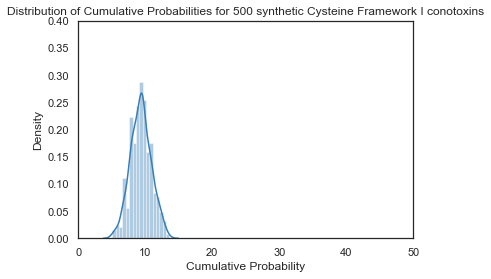

In [39]:
sns.distplot(second_trial_df['Cumulative Probability'], color='#377eb8')
plt.xlim(0,50)
plt.ylim(0,0.4)
plt.title('Distribution of Cumulative Probabilities for 500 synthetic Cysteine Framework I conotoxins')
#plt.savefig(figpath+"Distribution of Cumulative Probabilities for 500 synthetic Cysteine Framework I conotoxins.pdf")
#plt.close()
plt.show()

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


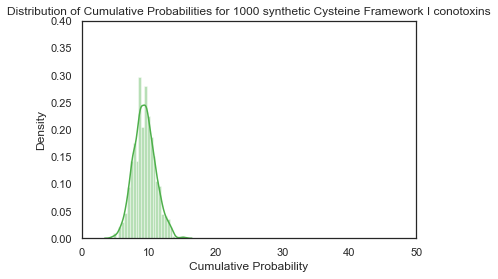

In [40]:
sns.distplot(third_trial_df['Cumulative Probability'], color='#4daf4a')
plt.xlim(0,50)
plt.ylim(0,0.4)
plt.title('Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins')
#plt.savefig(figpath+"Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins.pdf")
#plt.close()
plt.show()

So far very few to no (children) sequences share the frequency distribution of the parent sequences. We are going to reduce the number of possibilities in the ppm_dict and only keep residues >0.02-0.25

5.Generate new sequences with residues probabilities > 0.02-0.25

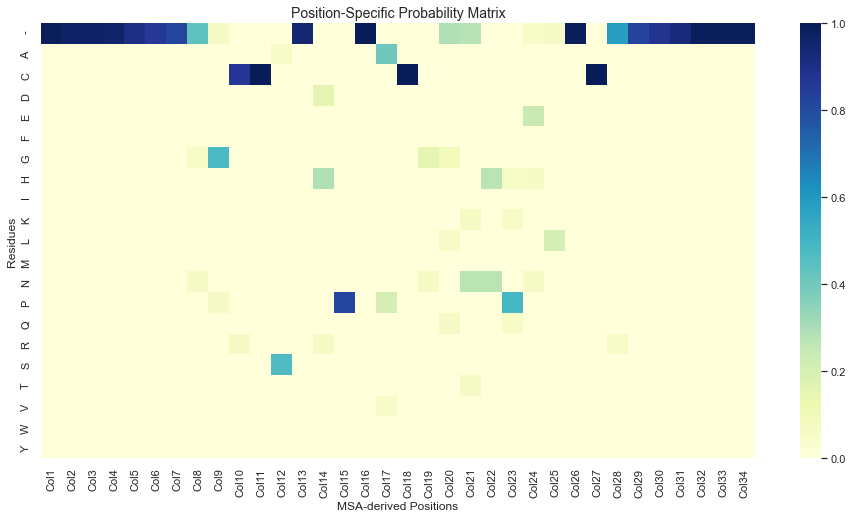

In [41]:
# Generate PSPM heatmaps with different thresholds 
thr_list = [0.02, 0.05, 0.10, 0.15, 0.20, 0.25]
for thr in thr_list:
    minor_residues = np.arange(0.01, thr+0.01, 0.01)
    trimmed_ppm = ppm.replace(to_replace = minor_residues, value = 0.0)
    
    #Visualize trimmed probability matrix
    fig, ax = plt.subplots(figsize=(16,8))
    sns.heatmap(trimmed_ppm, vmin=0, vmax=1, cmap="YlGnBu")
    plt.ylabel('Residues')
    plt.xlabel('MSA-derived Positions')
    plt.title('Position-Specific Probability Matrix', fontsize=14)
    #plt.savefig(figpath+"Heatmap_Position-Specific Probability Matrix (346 toxins)_threshold_"+str(thr)+".pdf")
    #plt.close()
    plt.show()

In [42]:
# Generate 1000 sequences with a given threshold and save it into a dataframe
thr_list = [0.02, 0.05, 0.10, 0.15, 0.20, 0.25]
for thr in thr_list:
    minor_residues = np.arange(0.01, thr+0.01, 0.01)
    trimmed_ppm = ppm.replace(to_replace = minor_residues, value = 0.0)
    
    trimmed_ppm_dict = trimmed_ppm.to_dict()
    cleaned_ppm_dict = remove_empty_from_dict(trimmed_ppm_dict)
    
    #Generating new sequences
    N=1000
    ids2 = ['conotoxin.{}'.format(i) for i in range(1, N+1)]
    sequences = []
    for _ in range(N):
        s1 = seq_prob(cleaned_ppm_dict)
        sequences.append(s1)

    # Calculating their cumulative probabilities and distribution of cumulative probabilities
    cumprobs = []
    cumdists = []
    for s2 in sequences:
        cumprobs.append(cumulative_probability(s2))
        cumdists.append(cumulative_distribution(s2))
    
    df = pd.DataFrame(list(zip(sequences, cumdists, cumprobs)), columns =['Sequence', 'Cumulative Distribution', 'Cumulative Probability'], index=ids2)
    df.to_csv('C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/dataframes/generated_conotoxins_df_{}.csv'.format(thr))

In [43]:
firstgen_2_df = pd.read_csv('C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/dataframes/generated_conotoxins_df_0.02.csv', index_col=0)
firstgen_5_df = pd.read_csv('C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/dataframes/generated_conotoxins_df_0.05.csv', index_col=0)
firstgen_10_df = pd.read_csv('C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/dataframes/generated_conotoxins_df_0.1.csv', index_col=0)
firstgen_15_df = pd.read_csv('C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/dataframes/generated_conotoxins_df_0.15.csv', index_col=0)
firstgen_20_df = pd.read_csv('C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/dataframes/generated_conotoxins_df_0.2.csv', index_col=0)
firstgen_25_df = pd.read_csv('C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/dataframes/generated_conotoxins_df_0.25.csv', index_col=0)

- Probability > 0.02

Text(0.5, 1.0, 'Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.02)')

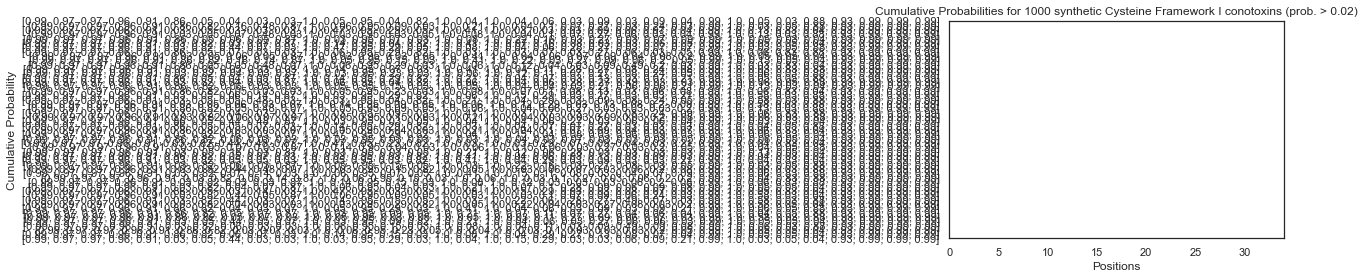

In [44]:
sns.set()
sns.set_style("white")
for i in range(100):
    x = firstgen_2_df['Cumulative Distribution'][i]
    plt.plot(pd.Series(x).cumsum(), color='#e41a1c', linewidth=0.3)
    plt.xlim(0,34)
    plt.ylim(0,50)

plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.02)')
#plt.savefig(figpath+"Cumulative Probability for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.02).pdf")
#plt.show()
#plt.close()


c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.02)')

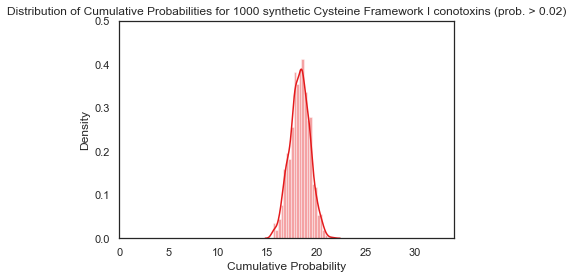

In [45]:
sns.distplot(firstgen_2_df['Cumulative Probability'], color='#e41a1c')
plt.xlim(0,34)
plt.ylim(0,0.5)
plt.title('Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.02)')
#plt.savefig(figpath+"Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.02).pdf")
#plt.close()
#plt.show()

Probability > 0.05

Text(0.5, 1.0, 'Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.05)')

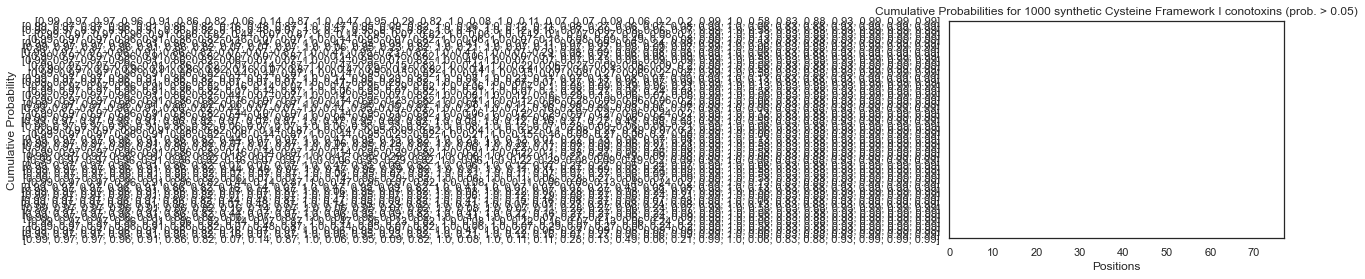

In [46]:
sns.set()
sns.set_style("white")
for i in range(100):
    x = firstgen_5_df['Cumulative Distribution'][i]
    plt.plot(pd.Series(x).cumsum(), color='#377eb8', linewidth=0.3)
    plt.xlim(0,77)
    plt.ylim(0,50)

plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.05)')
#plt.savefig(path.join(figpath, "Cumulative Probability for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.05).pdf"))
#plt.close()
#plt.show()

In [47]:
sns.distplot(firstgen_5_df['Cumulative Probability'], color='#377eb8')
plt.xlim(0,80)
plt.ylim(0,0.8)
plt.title('Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.05)')
#plt.savefig(figpath+"Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.05).pdf")
#plt.close()
#plt.show()

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.05)')

Probability > 0.10

In [48]:
sns.set()
sns.set_style("white")
for i in range(100):
    x = firstgen_10_df['Cumulative Distribution'][i]
    plt.plot(pd.Series(x).cumsum(), color='#4daf4a', linewidth=0.3)
    plt.xlim(0,77)
    plt.ylim(0,50)

plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.10)')
#plt.savefig(path.join(figpath, "Cumulative Probability for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.10).pdf"))
#plt.close()
#plt.show()

Text(0.5, 1.0, 'Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.10)')

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.10)')

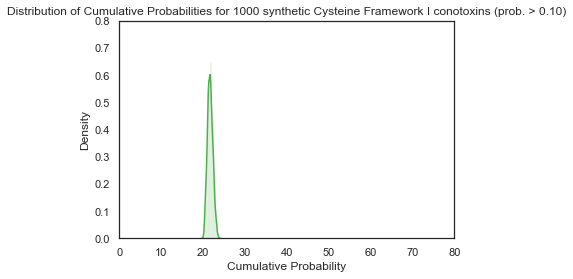

In [49]:
sns.distplot(firstgen_10_df['Cumulative Probability'], color='#4daf4a')
plt.xlim(0,80)
plt.ylim(0,0.8)
plt.title('Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.10)')
#plt.savefig(figpath+"Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.10).pdf")
#plt.close()
#plt.show()

Probability > 0.15

Text(0.5, 1.0, 'Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.15)')

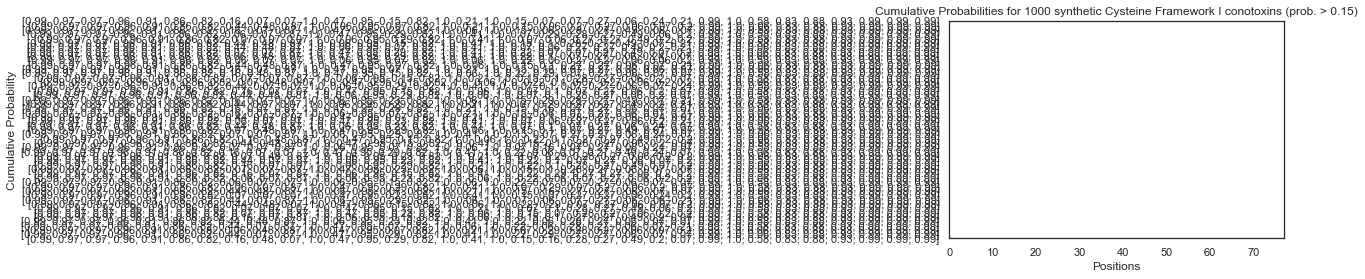

In [50]:
sns.set()
sns.set_style("white")
for i in range(100):
    x = firstgen_15_df['Cumulative Distribution'][i]
    plt.plot(pd.Series(x).cumsum(), color='#984ea3', linewidth=0.3)
    plt.xlim(0,77)
    plt.ylim(0,50)

plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.15)')
#plt.savefig(figpath+"Cumulative Probability for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.15).pdf"))
#plt.close()
#plt.show()

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.15)')

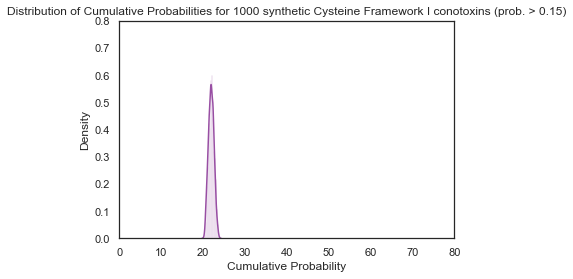

In [51]:
sns.distplot(firstgen_15_df['Cumulative Probability'], color='#984ea3')
plt.xlim(0,80)
plt.ylim(0,0.8)
plt.title('Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.15)')
#plt.savefig(figpath+"Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.15).pdf")
#plt.close()
#plt.show()

Probability > 0.20

Text(0.5, 1.0, 'Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.20)')

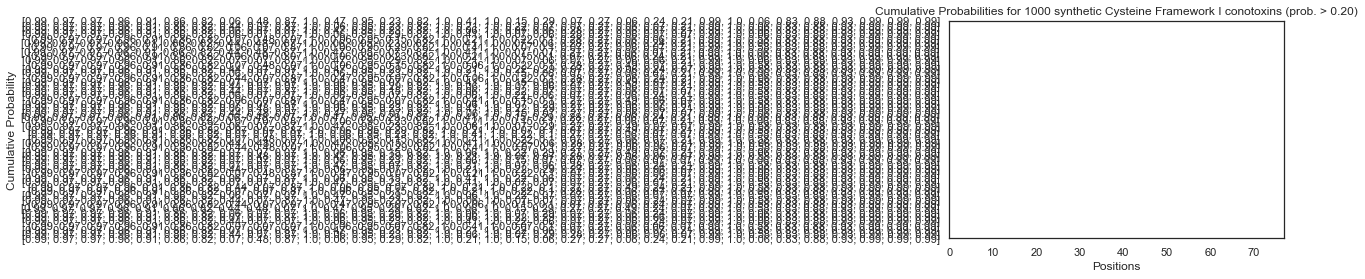

In [52]:
sns.set()
sns.set_style("white")
for i in range(100):
    x = firstgen_20_df['Cumulative Distribution'][i]
    plt.plot(pd.Series(x).cumsum(), color='#ff7f00', linewidth=0.3)
    plt.xlim(0,77)
    plt.ylim(0,50)

plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.20)')
#plt.savefig(figpath+"Cumulative Probability for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.20).pdf")
#plt.close()
#plt.show()

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


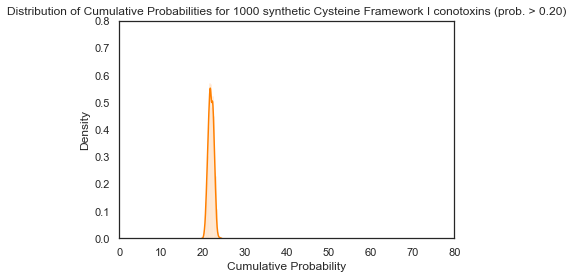

In [53]:
sns.distplot(firstgen_20_df['Cumulative Probability'], color='#ff7f00')
plt.xlim(0,80)
plt.ylim(0,0.8)
plt.title('Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.20)')
#plt.savefig(figpath+"Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.20).pdf")
#plt.close()
plt.show()

Text(0.5, 1.0, 'Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.25)')

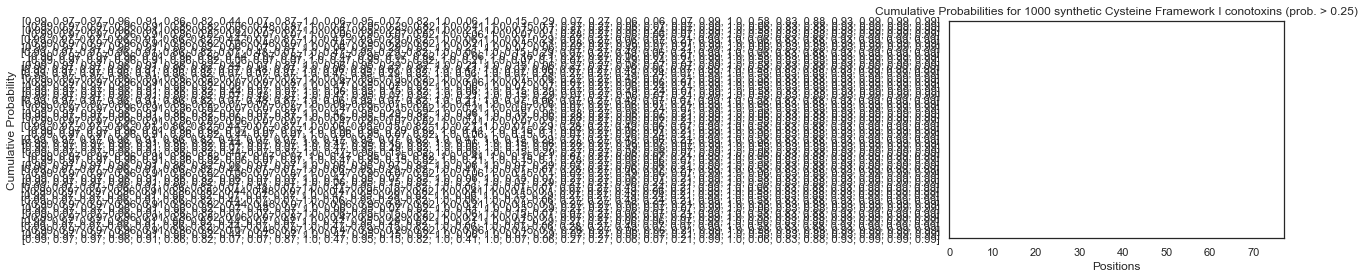

In [54]:
sns.set()
sns.set_style("white")
for i in range(100):
    x = firstgen_25_df['Cumulative Distribution'][i]
    plt.plot(pd.Series(x).cumsum(), color='#ffd92f', linewidth=0.3)
    plt.xlim(0,77)
    plt.ylim(0,50)

plt.xlabel('Positions')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.25)')
#plt.savefig(figpath+"Cumulative Probability for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.25).pdf")
#plt.close()
#plt.show()

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


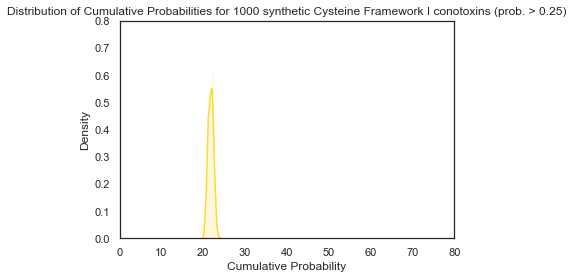

In [55]:
sns.distplot(firstgen_25_df['Cumulative Probability'], color='#ffd92f')
plt.xlim(0,80)
plt.ylim(0,0.8)
plt.title('Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (prob. > 0.25)')
#plt.savefig(figpath+"Distribution of Cumulative Probabilities for 1000 synthetic Cysteine Framework I conotoxins (probability > 0.25).pdf")
#plt.close()
plt.show()

In [56]:
plt.figure(figsize=(7,4))
sns.set_style("white")
sns.distplot(real_conotoxins_df['Cumulative_Probability'], color='black', hist=False, label='real', kde_kws={'alpha': 0.7})
sns.distplot(firstgen_2_df['Cumulative Probability'], color='#e41a1c', hist=False, label='> 0.02', kde_kws={'alpha': 0.7})
sns.distplot(firstgen_5_df['Cumulative Probability'], color='#377eb8', hist=False, label='> 0.05', kde_kws={'alpha': 0.7})
sns.distplot(firstgen_10_df['Cumulative Probability'], color='#4daf4a', hist=False, label='> 0.10', kde_kws={'alpha': 0.7})
sns.distplot(firstgen_15_df['Cumulative Probability'], color='#984ea3', hist=False, label='> 0.15', kde_kws={'alpha': 0.7})
sns.distplot(firstgen_20_df['Cumulative Probability'], color='#ff7f00', hist=False, label='> 0.20', kde_kws={'alpha': 0.7})
sns.distplot(firstgen_25_df['Cumulative Probability'], color='#ffd92f', hist=False, label='> 0.25', kde_kws={'alpha': 0.7})
plt.xlim(0,80)
plt.ylim(0,0.8)
ax = plt.axes()
ax.legend(loc='upper right', frameon=True)
plt.title('Distribution of Cumulative Probabilities for all synthetic Cysteine Framework I conotoxins')
plt.savefig(path.join(figpath, "probe.pdf"))
#plt.close()
plt.show()

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt you

In [57]:
Repeat(firstgen_25_df.Sequence) # No duplicated sequence

[]

In [58]:
common_member(firstgen_25_df.Sequence, real_conotoxins_df.Sequence)

No common elements


In [59]:
# Save all new sequences as fasta files
def fasta_converter(database):
    '''Use the indices of the database and the column 'Sequence' to create a fasta file'''
    #filepath = 'C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/{}.fasta'.format(database) Format not working
    ofile = open('C:/Users/JGO/Desktop/LANGEBIO/JupyterNotebook/CysFI/firstgen_25_df.fasta', "w")

    for i in range(len(database.Sequence)):

        ofile.write(">" + database.index[i] + "\n" + database.Sequence[i] + "\n")
        
    ofile.close()

In [60]:
fasta_converter(firstgen_2_df)

In [61]:
fasta_converter(firstgen_5_df)

In [62]:
fasta_converter(firstgen_10_df)

In [63]:
fasta_converter(firstgen_15_df)

In [64]:
fasta_converter(firstgen_20_df)

In [65]:
fasta_converter(firstgen_25_df)

We successfully generated sequences that display similar range of cumulative probabilities than the 246 real conotoxins meaning that they share similar residues at given positions. And yet, there is no duplicated sequences or identical sequences between datasets. The next challenge should be to build a discriminatory algorithm that can differentiate between real and synthetic (fake/generated) sequences (this is the second network in GANs models).

#### Discriminatory algorithm

A discriminatory algorithm is a classical classification problem that aims at predicting which peptide sequence is natural or generated (fake/synthetic). In order to build the classification model(s) we will;

1- Select 1200 from 6000 synthetic peptide sequences (150-300 from the 6 firstgen dataframes) as well as the 246 natural sequences.

2- Encode the dataset (Zappo encoding) and add the class labeling (0: generated, 1: natural)

3- Split into training/test/validation sets

4- Apply oversampling methods ROSE and SMOTE and 10-fold cross-validation

5- Test several binary classifiers (Accuracy): CART, RF, GBC, LogReg, SVM, NB, LDA, QDA

1. Select 1200 from 6000 synthetic peptide sequences (150-300 from the 6 firstgen dataframes) 

In [66]:
frames = [firstgen_2_df.sample(150), firstgen_5_df.sample(150), firstgen_10_df.sample(150), firstgen_15_df.sample(350), firstgen_20_df.sample(250) , firstgen_25_df.sample(150)]

synthetic_seqs = pd.concat(frames)

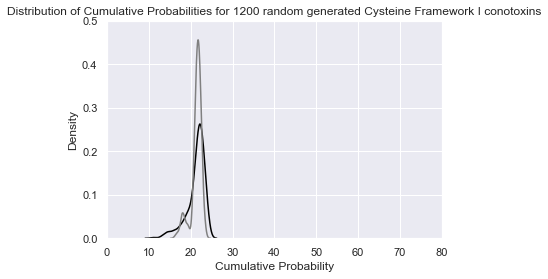

In [96]:
sns.distplot(real_conotoxins_df['Cumulative_Probability'], color='black', hist=False, label='real', kde_kws={'alpha': 0.7})
sns.distplot(synthetic_seqs['Cumulative Probability'], color='grey', hist=False, label='generated', kde_kws={'alpha': 0.7})
plt.xlim(0,80)
plt.ylim(0,0.5)
plt.title('Distribution of Cumulative Probabilities for 1200 random generated Cysteine Framework I conotoxins')
ax.legend(loc='upper right', frameon=True)
#plt.savefig(path.join(figpath, "Distribution of Cumulative Probabilities for 1200 random generate beta-toxins.pdf"))
#plt.close()
plt.show()

We adjusted the 'weights' of how many sequences were sampled from each firstgen datasets so the distribution of random selected generated peptide sequences reflects the distribution of real (natural) conotoxins.

In [68]:
# Add the 346 real conotoxins (1546 sequences in total)
frames2 = [synthetic_seqs['Sequence'], real_conotoxins_df['Sequence']]
model_seqs = pd.concat(frames2)
model_seqs

conotoxin.762    -----I-QARCC-HS-TCWELYSQH-CS-R----
conotoxin.451    -------N-CCG-PH-VCHVK-PVY-CRC-----
conotoxin.157    -----IRLP-CC-HH-VCSLDYS-K-CS-R----
conotoxin.575    -----I-PG-CP-IH-ACHLDHP-N-CGCR----
conotoxin.371    -------NTRCC-LG-TCWL-KNFK-CD-R----
                                ...                
P06520           ----AIGGTCCP-IP-SCASTFPRL-C-------
P04193           ---TVIMHNCCT-RS-FCKRIYPDL-CS------
P04195           ----GIRGNCCM-FH-TCPIDYSRFYCP------
P04194           ----GIRGNCCM-FH-TCPIDYSRFNCP------
P04934           -------RPCCS-LR-WCS----NY-CRCGI---
Name: Sequence, Length: 1546, dtype: object

#Split list of sequences into a list of lists of characters then turn it into a dataframe
def split(Alignment):
    Split_df = []
    ids =[]
    for seq in SeqIO.parse(Alignment,'fasta'):
        split_seq = [char for char in seq]
        Split_df.append(split_seq)
        ids.append(seq.id)
    alignment_length = len(Split_df[0])
    col_names = list(map('Col{}'.format, range(1,alignment_length+1)))
    Split_df = pd.DataFrame(Split_df, columns = col_names, index=ids)
    return Split_df

chars_model_seqs = []    
for seq in model_seqs:
    chars_model_seq = split(model_seqs)
    chars_model_seqs.append(chars_model_seq)
    
X_chars_model = pd.DataFrame(chars_model_seqs, columns = col_names, index=model_seqs.index)
X_chars_model

In [69]:
#Split list of sequences into a list of lists of characters then turn it into a dataframe
def split(seq): 
    return [char for char in seq]

chars_model_seqs = []    
for seq in model_seqs:
    chars_model_seq = split(seq)
    chars_model_seqs.append(chars_model_seq)

#col_names = list(map('Col{}'.format, str(range(1,chars_model_seqs+1))))
    
X_chars_model = pd.DataFrame(chars_model_seqs, index=model_seqs.index)
X_chars_model

0  1  2  3  4  5  6  7  8  9   ... 24 25 26 27 28 29 30 31 32 33
conotoxin.762  -  -  -  -  -  I  -  Q  A  R  ...  H  -  C  S  -  R  -  -  -  -
conotoxin.451  -  -  -  -  -  -  -  N  -  C  ...  Y  -  C  R  C  -  -  -  -  -
conotoxin.157  -  -  -  -  -  I  R  L  P  -  ...  K  -  C  S  -  R  -  -  -  -
conotoxin.575  -  -  -  -  -  I  -  P  G  -  ...  N  -  C  G  C  R  -  -  -  -
conotoxin.371  -  -  -  -  -  -  -  N  T  R  ...  K  -  C  D  -  R  -  -  -  -
...           .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
P06520         -  -  -  -  A  I  G  G  T  C  ...  L  -  C  -  -  -  -  -  -  -
P04193         -  -  -  T  V  I  M  H  N  C  ...  L  -  C  S  -  -  -  -  -  -
P04195         -  -  -  -  G  I  R  G  N  C  ...  F  Y  C  P  -  -  -  -  -  -
P04194         -  -  -  -  G  I  R  G  N  C  ...  F  N  C  P  -  -  -  -  -  -
P04934         -  -  -  -  -  -  -  R  P  C  ...  Y  -  C  R  C  G  I  -  -  -

[1546 rows x 34 columns]

2- Encode the dataset(Zappo encoding), add the class labeling (0: generated, 1: natural) and resample the chars_model dataset with ROSE/SMOTE and ADASYN methods

In [70]:
def Zappo_encoding(dataframe):
    codes = {'-': 0, 'I|L|V|A|M': 1, 'F|W|Y': 2, 'K|R|H': 3, 'D|E':4, 'S|T|N|Q|B': 5, 'P|G': 6 , 'C': 7}
    new_dataframe = dataframe.replace(regex=codes)
    return new_dataframe

In [71]:
X_model = Zappo_encoding(X_chars_model)
X_model.head(10)

0   1   2   3   4   5   6   7   8   9   ...  24  25  26  27  \
conotoxin.762   0   0   0   0   0   1   0   5   1   3  ...   3   0   7   5   
conotoxin.451   0   0   0   0   0   0   0   5   0   7  ...   2   0   7   3   
conotoxin.157   0   0   0   0   0   1   3   1   6   0  ...   3   0   7   5   
conotoxin.575   0   0   0   0   0   1   0   6   6   0  ...   5   0   7   6   
conotoxin.371   0   0   0   0   0   0   0   5   5   3  ...   3   0   7   4   
conotoxin.380   0   0   0   0   0   0   0   5   5   3  ...   5   0   7   3   
conotoxin.302   0   0   0   0   0   0   3   5   0   0  ...   1   0   7   4   
conotoxin.20    0   0   0   0   0   0   0   5   0   0  ...   3   0   7   4   
conotoxin.418   0   0   0   0   0   0   0   6   4   3  ...   5   0   7   5   
conotoxin.851   0   0   0   0   0   0   0   4   4   0  ...   5   0   7   5   

               28  29  30  31  32  33  
conotoxin.762   0   3   0   0   0   0  
conotoxin.451   7   0   0   0   0   0  
conotoxin.157   0   3   0   0   0   0  
conotoxin.575   7   3   0   0   0   0  
conotoxin.371   0   3   0   0   0   0  
conotoxin.380   7   0   0   0   0   0  
conotoxin.302   6   3   0   0   0   0  
conotoxin.20    7   3   0   0   0   0  
conotoxin.418   7   0   0   0   0   0  
conotoxin.851   7   0   0   0   0   0  

[10 rows x 34 columns]

In [72]:
y_model = [0]*1200 + [1] *346

from collections import Counter
print(sorted(Counter(y_model).items()))

[(0, 1200), (1, 346)]


In [73]:
len(synthetic_seqs)

1200

In [74]:
len(real_conotoxins_df['Sequence'])

346

In [75]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

In [76]:
ros = RandomOverSampler(random_state=42)
X_model_ros, y_model_ros = ros.fit_resample(X_model, y_model)
X_chars_model_ros, y_model_ros = ros.fit_resample(X_chars_model, y_model) # only ROSE allows direct resampling from character-filled dataframe.

smote = SMOTE(random_state=42)
X_model_smote, y_model_smote = smote.fit_resample(X_model, y_model)

adasyn = ADASYN(random_state=42)
X_model_adasyn, y_model_adasyn = adasyn.fit_resample(X_model, y_model)

In [77]:
print(sorted(Counter(y_model_ros).items()))
print(sorted(Counter(y_model_smote).items()))
print(sorted(Counter(y_model_adasyn).items()))

[(0, 1200), (1, 1200)]
[(0, 1200), (1, 1200)]
[(0, 1200), (1, 1190)]


In [78]:
# Convert back all X_chars_model_ros columns into sequences
merged_seqs_ros = X_chars_model_ros[X_chars_model_ros.columns].astype(str).apply(lambda x: ''.join(x), axis = 1)
merged_seqs_ros

0       -----I-QARCC-HS-TCWELYSQH-CS-R----
1       -------N-CCG-PH-VCHVK-PVY-CRC-----
2       -----IRLP-CC-HH-VCSLDYS-K-CS-R----
3       -----I-PG-CP-IH-ACHLDHP-N-CGCR----
4       -------NTRCC-LG-TCWL-KNFK-CD-R----
                       ...                
2395    --------GCCS-FP-ACRKYRPEM-CG------
2396    -------SACCG-YK-LC---SP---CGQA----
2397    -------NGRCC-HP-ACG--KHFS-C-------
2398    -------RPCCY-IG-WCS----RR-CNCGGYRP
2399    --------GCCS-HP-PCAMNNPDY-C-------
Length: 2400, dtype: object

In [79]:
merged_seqs_ros_df = pd.DataFrame(merged_seqs_ros, columns=['Sequence'])
merged_seqs_ros_df # 2400 sequences (1200 generated, 1107 replicates of 346, 346 real btoxins)

Sequence
0     -----I-QARCC-HS-TCWELYSQH-CS-R----
1     -------N-CCG-PH-VCHVK-PVY-CRC-----
2     -----IRLP-CC-HH-VCSLDYS-K-CS-R----
3     -----I-PG-CP-IH-ACHLDHP-N-CGCR----
4     -------NTRCC-LG-TCWL-KNFK-CD-R----
...                                  ...
2395  --------GCCS-FP-ACRKYRPEM-CG------
2396  -------SACCG-YK-LC---SP---CGQA----
2397  -------NGRCC-HP-ACG--KHFS-C-------
2398  -------RPCCY-IG-WCS----RR-CNCGGYRP
2399  --------GCCS-HP-PCAMNNPDY-C-------

[2400 rows x 1 columns]

In [80]:
synthetic_seqs

Sequence  \
conotoxin.762  -----I-QARCC-HS-TCWELYSQH-CS-R----   
conotoxin.451  -------N-CCG-PH-VCHVK-PVY-CRC-----   
conotoxin.157  -----IRLP-CC-HH-VCSLDYS-K-CS-R----   
conotoxin.575  -----I-PG-CP-IH-ACHLDHP-N-CGCR----   
conotoxin.371  -------NTRCC-LG-TCWL-KNFK-CD-R----   
...                                           ...   
conotoxin.259  -------NGRCA-HP-ACNQ-HQ---CR------   
conotoxin.98   --------PRCS-RP-ACNGTHKEL-CR------   
conotoxin.81   -------GGRCS-HP-ACG--HKH--CR------   
conotoxin.318  --------PRCA-DP-ACGLNHQNL-C-------   
conotoxin.450  ---------RCA-DP-PCNL-NHN--C-------   

                                         Cumulative Distribution  \
conotoxin.762  [0.99, 0.97, 0.97, 0.96, 0.91, 0.03, 0.82, 0.0...   
conotoxin.451  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.0...   
conotoxin.157  [0.99, 0.97, 0.97, 0.96, 0.91, 0.03, 0.05, 0.0...   
conotoxin.575  [0.99, 0.97, 0.97, 0.96, 0.91, 0.03, 0.82, 0.0...   
conotoxin.371  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.0...   
...                                                          ...   
conotoxin.259  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.0...   
conotoxin.98   [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.4...   
conotoxin.81   [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.0...   
conotoxin.318  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.4...   
conotoxin.450  [0.99, 0.97, 0.97, 0.96, 0.91, 0.86, 0.82, 0.4...   

               Cumulative Probability  
conotoxin.762                   17.34  
conotoxin.451                   19.45  
conotoxin.157                   16.72  
conotoxin.575                   17.77  
conotoxin.371                   18.26  
...                               ...  
conotoxin.259                   21.17  
conotoxin.98                    21.46  
conotoxin.81                    21.88  
conotoxin.318                   21.72  
conotoxin.450                   21.31  

[1200 rows x 3 columns]

In [81]:
# We only want to see the distribution of cumulative probabilities derived from resampled real conotoxins, first we need to remove all synthetic sequences.
merged_conotoxins_ros = merged_seqs_ros_df.merge(synthetic_seqs.Sequence,on=['Sequence'],how='right') # merge 1200 generated
real_conotoxins_ros = merged_conotoxins_ros.drop_duplicates() #1290 sequences
real_conotoxins_ros

Sequence
0     -----I-QARCC-HS-TCWELYSQH-CS-R----
1     -------N-CCG-PH-VCHVK-PVY-CRC-----
2     -----IRLP-CC-HH-VCSLDYS-K-CS-R----
3     -----I-PG-CP-IH-ACHLDHP-N-CGCR----
4     -------NTRCC-LG-TCWL-KNFK-CD-R----
...                                  ...
1195  -------NGRCA-HP-ACNQ-HQ---CR------
1196  --------PRCS-RP-ACNGTHKEL-CR------
1197  -------GGRCS-HP-ACG--HKH--CR------
1198  --------PRCA-DP-ACGLNHQNL-C-------
1199  ---------RCA-DP-PCNL-NHN--C-------

[1200 rows x 1 columns]

In [82]:
cumprobs = []
for s in real_conotoxins_ros.Sequence:
    cumprobs.append(cumulative_probability(s))

#print(cumprobs)

ids3 = ['r_conotoxin{}'.format(i) for i in range(1, 1201)]
real_conotoxins_ros_df = pd.DataFrame(list(zip(real_conotoxins_ros.Sequence, cumprobs)), columns =['Sequence', 'Cumulative_Probability'], index=ids3)
real_conotoxins_ros_df

Sequence  Cumulative_Probability
r_conotoxin1     -----I-QARCC-HS-TCWELYSQH-CS-R----                   17.34
r_conotoxin2     -------N-CCG-PH-VCHVK-PVY-CRC-----                   19.45
r_conotoxin3     -----IRLP-CC-HH-VCSLDYS-K-CS-R----                   16.72
r_conotoxin4     -----I-PG-CP-IH-ACHLDHP-N-CGCR----                   17.77
r_conotoxin5     -------NTRCC-LG-TCWL-KNFK-CD-R----                   18.26
...                                             ...                     ...
r_conotoxin1196  -------NGRCA-HP-ACNQ-HQ---CR------                   21.17
r_conotoxin1197  --------PRCS-RP-ACNGTHKEL-CR------                   21.46
r_conotoxin1198  -------GGRCS-HP-ACG--HKH--CR------                   21.88
r_conotoxin1199  --------PRCA-DP-ACGLNHQNL-C-------                   21.72
r_conotoxin1200  ---------RCA-DP-PCNL-NHN--C-------                   21.31

[1200 rows x 2 columns]

c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\users\jgo\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt you

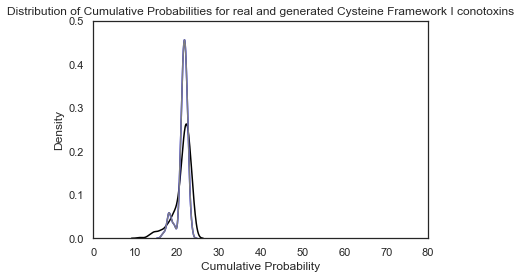

In [83]:
sns.distplot(real_conotoxins_df['Cumulative_Probability'], color='black', hist=False, label='real', kde_kws={'alpha': 0.7})
sns.distplot(real_conotoxins_ros_df['Cumulative_Probability'], color='blue', hist=False, label='real (ROS)', kde_kws={'alpha': 0.7})
sns.distplot(synthetic_seqs['Cumulative Probability'], color='grey', hist=False, label='generated', kde_kws={'alpha': 0.7})
plt.xlim(0,80)
plt.ylim(0,0.5)
plt.title('Distribution of Cumulative Probabilities for real and generated Cysteine Framework I conotoxins')
#plt.savefig(path.join(figpath, "Distribution of Cumulative Probabilities for 1200 random generate beta-toxins.pdf"))
#plt.close()
plt.show()

Using resampling method ROS (Random Over Sampling) to oversample the real beta-toxins dataset has not led to a shift in the distribution of cumulative proabilities. Such comparison is not easily feasible to observe the effects of SMOTE and ADASYN resampling for several reasons (1) both resampling methods do not apply on character-filled dataframe [both methods require Zappo-encoding prior to resample] and (2) it will require to reverse Zappo-encoding numbers to corresponding amino acids, each number correspond to 1-5 amino acids leading to (5^77*1200) 8*10^58 possible sequences.

In [84]:
from os import path
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score, matthews_corrcoef, average_precision_score
from sklearn.metrics import classification_report

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

In [86]:
from sklearn.model_selection import train_test_split, KFold
seed=42
kfold = KFold(n_splits=10, random_state=seed, shuffle= True)

In [87]:
models = []
models.append(('logreg', LogisticRegression(fit_intercept=True)))
models.append(('knn', KNeighborsClassifier()))
models.append(('cart', DecisionTreeClassifier(random_state=seed)))
models.append(('rfc', RandomForestClassifier(random_state=seed, max_depth=5, n_jobs=10)))
models.append(('gbc', GradientBoostingClassifier(random_state=seed)))
models.append(('adc', AdaBoostClassifier()))
models.append(('lda', LinearDiscriminantAnalysis()))
models.append(('qda', QuadraticDiscriminantAnalysis()))
models.append(('nb', GaussianNB()))
models.append(('svc_lr', SVC(kernel="linear", C=0.025)))
models.append(('svc_rbf', SVC(gamma=2, C=1, probability=True)))
models.append(('svc_poly', SVC(kernel="poly", probability=True)))
models.append(('svc_sig', SVC(kernel="sigmoid", probability=True)))

In [88]:
#Remove positions with high collinearity
corr_matrix = X_model_ros.corr()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X_model_ros_trim = X_model_ros.drop(X_model_ros[to_drop], axis=1)

X_model, X_val, y_model_2cl, y_val_2cl = train_test_split(X_model_ros_trim, y_model_ros, test_size=0.2, random_state=42)

In [89]:
import warnings
warnings.filterwarnings('ignore')

logreg: Accuracy Score 86.41% (2.89%)
logreg: Accuracy 86.41%
logreg: Precision-Recall 81.00%
logreg: Matthews Coefficient 72.89%
logreg: Cohen Kappa Score 72.80%
logreg: ROC AUC Score 86.38%
              precision    recall  f1-score   support

       low 0       0.88      0.84      0.86       952
      high 1       0.85      0.89      0.87       968

    accuracy                           0.86      1920
   macro avg       0.87      0.86      0.86      1920
weighted avg       0.86      0.86      0.86      1920

logreg: Accuracy 84.79%
logreg: Precision-Recall 78.30%
logreg: Matthews Coefficient 69.61%
logreg: Cohen Kappa Score 69.58%
logreg: ROC AUC Score 84.82%
              precision    recall  f1-score   support

       low 0       0.86      0.84      0.85       248
      high 1       0.83      0.86      0.85       232

    accuracy                           0.85       480
   macro avg       0.85      0.85      0.85       480
weighted avg       0.85      0.85      0.85       480



nb: Accuracy 61.25%
nb: Precision-Recall 58.58%
nb: Matthews Coefficient 33.66%
nb: Cohen Kappa Score 20.35%
nb: ROC AUC Score 59.91%
              precision    recall  f1-score   support

       low 0       0.57      1.00      0.73       248
      high 1       1.00      0.20      0.33       232

    accuracy                           0.61       480
   macro avg       0.79      0.60      0.53       480
weighted avg       0.78      0.61      0.54       480

svc_lr: Accuracy Score 87.19% (2.62%)
svc_lr: Accuracy 87.19%
svc_lr: Precision-Recall 81.28%
svc_lr: Matthews Coefficient 74.76%
svc_lr: Cohen Kappa Score 74.35%
svc_lr: ROC AUC Score 87.14%
              precision    recall  f1-score   support

       low 0       0.91      0.82      0.86       952
      high 1       0.84      0.92      0.88       968

    accuracy                           0.87      1920
   macro avg       0.88      0.87      0.87      1920
weighted avg       0.88      0.87      0.87      1920

svc_lr: Accuracy 85.

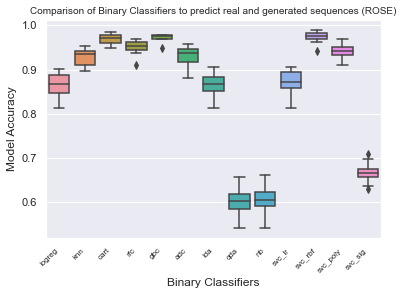

In [90]:
results = []
names = []

for name, model in models:
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_model, y_model_2cl, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_model, y_model_2cl, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_model_2cl, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_model_2cl, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_model_2cl, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_model_2cl, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_model_2cl, cv_preds)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_model_2cl, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_val, y_val_2cl, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_val_2cl, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_val_2cl, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_val_2cl, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_val_2cl, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_val_2cl, cv_preds2)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_val_2cl, cv_preds2, target_names=target_names))

sns.set()        
fig = sns.boxplot(data=results)
fig.set_xticklabels(names, rotation=45, horizontalalignment='right', fontsize=8)
fig.set_title('Comparison of Binary Classifiers to predict real and generated sequences (ROSE)', fontsize=10)
plt.xlabel('Binary Classifiers')
plt.ylabel('Model Accuracy')
plt.show()
#plt.savefig(path.join(figpath, "Comparison of Binary Classifiers for real and generated peptides_ROSE.pdf"))
#plt.close()

In [91]:
#Remove positions with high collinearity
corr_matrix2 = X_model_smote.corr()
# Select upper triangle of correlation matrix
upper = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X_model_smote_trim = X_model_smote.drop(X_model_smote[to_drop], axis=1)

X_model, X_val, y_model_2cl, y_val_2cl = train_test_split(X_model_smote_trim, y_model_smote, test_size=0.2, random_state=42)

logreg: Accuracy Score 86.77% (2.70%)
logreg: Accuracy 86.77%
logreg: Precision-Recall 81.21%
logreg: Matthews Coefficient 73.70%
logreg: Cohen Kappa Score 73.52%
logreg: ROC AUC Score 86.74%
              precision    recall  f1-score   support

       low 0       0.89      0.83      0.86       952
      high 1       0.85      0.90      0.87       968

    accuracy                           0.87      1920
   macro avg       0.87      0.87      0.87      1920
weighted avg       0.87      0.87      0.87      1920

logreg: Accuracy 84.79%
logreg: Precision-Recall 78.21%
logreg: Matthews Coefficient 69.64%
logreg: Cohen Kappa Score 69.59%
logreg: ROC AUC Score 84.84%
              precision    recall  f1-score   support

       low 0       0.87      0.83      0.85       248
      high 1       0.83      0.86      0.85       232

    accuracy                           0.85       480
   macro avg       0.85      0.85      0.85       480
weighted avg       0.85      0.85      0.85       480



nb: Accuracy 60.00%
nb: Precision-Recall 57.24%
nb: Matthews Coefficient 31.17%
nb: Cohen Kappa Score 17.71%
nb: ROC AUC Score 58.62%
              precision    recall  f1-score   support

       low 0       0.56      1.00      0.72       248
      high 1       1.00      0.17      0.29       232

    accuracy                           0.60       480
   macro avg       0.78      0.59      0.51       480
weighted avg       0.77      0.60      0.51       480

svc_lr: Accuracy Score 87.86% (2.53%)
svc_lr: Accuracy 87.86%
svc_lr: Precision-Recall 81.89%
svc_lr: Matthews Coefficient 76.25%
svc_lr: Cohen Kappa Score 75.70%
svc_lr: ROC AUC Score 87.81%
              precision    recall  f1-score   support

       low 0       0.93      0.82      0.87       952
      high 1       0.84      0.94      0.89       968

    accuracy                           0.88      1920
   macro avg       0.88      0.88      0.88      1920
weighted avg       0.88      0.88      0.88      1920

svc_lr: Accuracy 85.

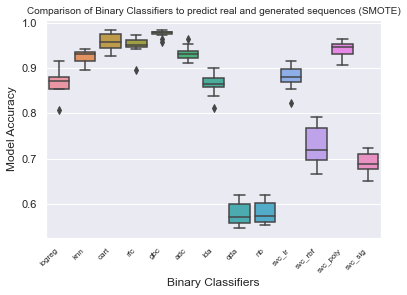

In [92]:
results = []
names = []

for name, model in models:
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_model, y_model_2cl, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_model, y_model_2cl, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_model_2cl, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_model_2cl, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_model_2cl, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_model_2cl, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_model_2cl, cv_preds)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_model_2cl, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_val, y_val_2cl, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_val_2cl, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_val_2cl, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_val_2cl, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_val_2cl, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_val_2cl, cv_preds2)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_val_2cl, cv_preds2, target_names=target_names))

sns.set()        
fig = sns.boxplot(data=results)
fig.set_xticklabels(names, rotation=45, horizontalalignment='right', fontsize=8)
fig.set_title('Comparison of Binary Classifiers to predict real and generated sequences (SMOTE)', fontsize=10)
plt.xlabel('Binary Classifiers')
plt.ylabel('Model Accuracy')
plt.show()
#plt.savefig(path.join(figpath, "Comparison of Binary Classifiers for real and generated peptides_SMOTE.pdf"))
#plt.close()

In [94]:
#Remove positions with high collinearity
corr_matrix3 = X_model_adasyn.corr()
# Select upper triangle of correlation matrix
upper = corr_matrix3.where(np.triu(np.ones(corr_matrix3.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
X_model_adasyn_trim = X_model_adasyn.drop(X_model_adasyn[to_drop], axis=1)

X_model, X_val, y_model_2cl, y_val_2cl = train_test_split(X_model_adasyn_trim, y_model_adasyn, test_size=0.2, random_state=42)

logreg: Accuracy Score 85.72% (2.53%)
logreg: Accuracy 85.72%
logreg: Precision-Recall 79.76%
logreg: Matthews Coefficient 71.63%
logreg: Cohen Kappa Score 71.44%
logreg: ROC AUC Score 85.72%
              precision    recall  f1-score   support

       low 0       0.89      0.82      0.85       956
      high 1       0.83      0.89      0.86       956

    accuracy                           0.86      1912
   macro avg       0.86      0.86      0.86      1912
weighted avg       0.86      0.86      0.86      1912

logreg: Accuracy 83.05%
logreg: Precision-Recall 76.24%
logreg: Matthews Coefficient 66.27%
logreg: Cohen Kappa Score 66.14%
logreg: ROC AUC Score 83.11%
              precision    recall  f1-score   support

       low 0       0.86      0.80      0.83       244
      high 1       0.81      0.86      0.83       234

    accuracy                           0.83       478
   macro avg       0.83      0.83      0.83       478
weighted avg       0.83      0.83      0.83       478



nb: Precision-Recall 58.77%
nb: Matthews Coefficient 32.92%
nb: Cohen Kappa Score 19.55%
nb: ROC AUC Score 59.62%
              precision    recall  f1-score   support

       low 0       0.56      1.00      0.72       244
      high 1       1.00      0.19      0.32       234

    accuracy                           0.60       478
   macro avg       0.78      0.60      0.52       478
weighted avg       0.78      0.60      0.53       478

svc_lr: Accuracy Score 86.72% (2.56%)
svc_lr: Accuracy 86.72%
svc_lr: Precision-Recall 80.16%
svc_lr: Matthews Coefficient 74.19%
svc_lr: Cohen Kappa Score 73.43%
svc_lr: ROC AUC Score 86.72%
              precision    recall  f1-score   support

       low 0       0.93      0.80      0.86       956
      high 1       0.82      0.94      0.88       956

    accuracy                           0.87      1912
   macro avg       0.87      0.87      0.87      1912
weighted avg       0.87      0.87      0.87      1912

svc_lr: Accuracy 83.89%
svc_lr: Precisio

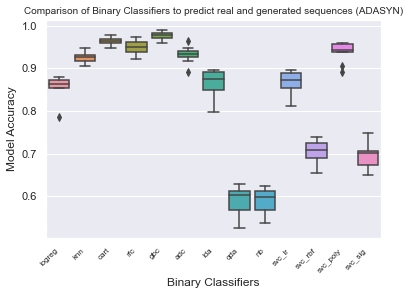

In [95]:
results = []
names = []

for name, model in models:
    # Scores means and std deviations
    cv_scores = model_selection.cross_val_score(model, X_model, y_model_2cl, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    print("%s: Accuracy Score %0.2f%% (%0.2f%%)" % (name, 100*cv_scores.mean(), 100*cv_scores.std()))
    
    # Predictions Model Set
    cv_preds = model_selection.cross_val_predict(model, X_model, y_model_2cl, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_model_2cl, cv_preds)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_model_2cl, cv_preds)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_model_2cl, cv_preds)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_model_2cl, cv_preds)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_model_2cl, cv_preds)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_model_2cl, cv_preds, target_names=target_names))
    
    # Predictions Validation Set
    cv_preds2 = model_selection.cross_val_predict(model, X_val, y_val_2cl, cv=kfold)
    print("%s: Accuracy %0.2f%%" % (name, 100*metrics.accuracy_score(y_val_2cl, cv_preds2)))
    print("%s: Precision-Recall %0.2f%%" % (name, 100*metrics.average_precision_score(y_val_2cl, cv_preds2)))
    print("%s: Matthews Coefficient %0.2f%%" % (name, 100*matthews_corrcoef(y_val_2cl, cv_preds2)))
    print("%s: Cohen Kappa Score %0.2f%%" % (name, 100*metrics.cohen_kappa_score(y_val_2cl, cv_preds2)))
    print("%s: ROC AUC Score %0.2f%%" % (name, 100*metrics.roc_auc_score(y_val_2cl, cv_preds2)))
    target_names = ['low 0', 'high 1']
    print(classification_report(y_val_2cl, cv_preds2, target_names=target_names))

sns.set()        
fig = sns.boxplot(data=results)
fig.set_xticklabels(names, rotation=45, horizontalalignment='right', fontsize=8)
fig.set_title('Comparison of Binary Classifiers to predict real and generated sequences (ADASYN)', fontsize=10)
plt.xlabel('Binary Classifiers')
plt.ylabel('Model Accuracy')
plt.show()
#plt.savefig(path.join(figpath, "Comparison of Binary Classifiers for real and generated peptides_ADASYN.pdf"))
#plt.close()

Indepently from the resampling methods, tree-based models (RFC, GBC, ADC) and SVM polynomial kernel outperformed other binary classifiers. All of these classifiers exhibit model and validation accuracies close to perfection (99.5%).

### Predictions the likeness of generated toxins to be real using selected models

In [133]:
#Prepare test datasets

#firstgen_2_df
fgen2_seqs = firstgen_2_df.Sequence
chars_test_seqs = []
for seq in fgen2_seqs:
    chars_test_seq = split(seq)
    chars_test_seqs.append(chars_test_seq)
    
X_chars_fgen2 = pd.DataFrame(chars_test_seqs, columns = col_names, index=fgen2_seqs.index)
X_fgen2 = Zappo_encoding(X_chars_fgen2)

#firstgen_5_df
fgen5_seqs = firstgen_5_df.Sequence
chars_test_seqs = []
for seq in fgen5_seqs:
    chars_test_seq = split(seq)
    chars_test_seqs.append(chars_test_seq)
    
X_chars_fgen5 = pd.DataFrame(chars_test_seqs, columns = col_names, index=fgen5_seqs.index)
X_fgen5 = Zappo_encoding(X_chars_fgen5)

#firstgen_10_df
fgen10_seqs = firstgen_10_df.Sequence
chars_test_seqs = []
for seq in fgen10_seqs:
    chars_test_seq = split(seq)
    chars_test_seqs.append(chars_test_seq)
    
X_chars_fgen10 = pd.DataFrame(chars_test_seqs, columns = col_names, index=fgen10_seqs.index)
X_fgen10 = Zappo_encoding(X_chars_fgen10)

#firstgen_15_df
fgen15_seqs = firstgen_15_df.Sequence
chars_test_seqs = []
for seq in fgen15_seqs:
    chars_test_seq = split(seq)
    chars_test_seqs.append(chars_test_seq)
    
X_chars_fgen15 = pd.DataFrame(chars_test_seqs, columns = col_names, index=fgen15_seqs.index)
X_fgen15 = Zappo_encoding(X_chars_fgen15)

#firstgen_20_df
fgen20_seqs = firstgen_20_df.Sequence
chars_test_seqs = []
for seq in fgen20_seqs:
    chars_test_seq = split(seq)
    chars_test_seqs.append(chars_test_seq)
    
X_chars_fgen20 = pd.DataFrame(chars_test_seqs, columns = col_names, index=fgen20_seqs.index)
X_fgen20 = Zappo_encoding(X_chars_fgen20)

#firstgen_25_df
fgen25_seqs = firstgen_25_df.Sequence
chars_test_seqs = []
for seq in fgen25_seqs:
    chars_test_seq = split(seq)
    chars_test_seqs.append(chars_test_seq)
    
X_chars_fgen25 = pd.DataFrame(chars_test_seqs, columns = col_names, index=fgen25_seqs.index)
X_fgen25 = Zappo_encoding(X_chars_fgen25)
X_fgen25.head(10)

NameError: name 'col_names' is not defined

In [108]:
#Remove positions with high collinearity
corr_matrix2 = X_model_smote.corr()
# Select upper triangle of correlation matrix
upper = corr_matrix2.where(np.triu(np.ones(corr_matrix2.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

X_fgen2_trim = X_fgen2.drop(X_fgen2[to_drop], axis=1)
X_fgen5_trim = X_fgen5.drop(X_fgen5[to_drop], axis=1)
X_fgen10_trim = X_fgen10.drop(X_fgen10[to_drop], axis=1)
X_fgen15_trim = X_fgen15.drop(X_fgen15[to_drop], axis=1)
X_fgen20_trim = X_fgen20.drop(X_fgen20[to_drop], axis=1)
X_fgen25_trim = X_fgen25.drop(X_fgen25[to_drop], axis=1)

In [116]:
svc_poly = SVC(kernel="poly", probability=True)
X_model, X_val, y_model_2cl, y_val_2cl = train_test_split(X_model_smote_trim, y_model_smote, test_size=0.2, random_state=42)
svc_poly.fit(X_model, y_model_2cl)

#first_2_gen_df
class_df = pd.DataFrame(svc_poly.predict(X_fgen2_trim))
probs_df = pd.DataFrame(svc_poly.predict_proba(X_fgen2_trim))
svc_poly_fgen2 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
svc_poly_fgen2.index = X_fgen2.index
svc_poly_fgen2.columns  = ['svc_poly_class_preds', 'svc_poly_probability_0', 'svc_poly_probability_1']

#first_5_gen_df
class_df = pd.DataFrame(svc_poly.predict(X_fgen5_trim))
probs_df = pd.DataFrame(svc_poly.predict_proba(X_fgen5_trim))
svc_poly_fgen5 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
svc_poly_fgen5.index = X_fgen5.index
svc_poly_fgen5.columns  = ['svc_poly_class_preds', 'svc_poly_probability_0', 'svc_poly_probability_1']

#first_10_gen_df
class_df = pd.DataFrame(svc_poly.predict(X_fgen10_trim))
probs_df = pd.DataFrame(svc_poly.predict_proba(X_fgen10_trim))
svc_poly_fgen10 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
svc_poly_fgen10.index = X_fgen10.index
svc_poly_fgen10.columns  = ['svc_poly_class_preds', 'svc_poly_probability_0', 'svc_poly_probability_1']

#first_15_gen_df
class_df = pd.DataFrame(svc_poly.predict(X_fgen15_trim))
probs_df = pd.DataFrame(svc_poly.predict_proba(X_fgen15_trim))
svc_poly_fgen15 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
svc_poly_fgen15.index = X_fgen15.index
svc_poly_fgen15.columns  = ['svc_poly_class_preds', 'svc_poly_probability_0', 'svc_poly_probability_1']

#first_20_gen_df
class_df = pd.DataFrame(svc_poly.predict(X_fgen20_trim))
probs_df = pd.DataFrame(svc_poly.predict_proba(X_fgen20_trim))
svc_poly_fgen20 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
svc_poly_fgen20.index = X_fgen20.index
svc_poly_fgen20.columns  = ['svc_poly_class_preds', 'svc_poly_probability_0', 'svc_poly_probability_1']

#first_25_gen_df
class_df = pd.DataFrame(svc_poly.predict(X_fgen25_trim))
probs_df = pd.DataFrame(svc_poly.predict_proba(X_fgen25_trim))
svc_poly_fgen25 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
svc_poly_fgen25.index = X_fgen25.index
svc_poly_fgen25.columns = ['svc_poly_class_preds', 'svc_poly_probability_0', 'svc_poly_probability_1']

In [122]:
import collections
print(Counter(svc_poly_fgen2.svc_poly_class_preds == 1))
print(Counter(svc_poly_fgen5.svc_poly_class_preds == 1))
print(Counter(svc_poly_fgen10.svc_poly_class_preds == 1))
print(Counter(svc_poly_fgen15.svc_poly_class_preds == 1))
print(Counter(svc_poly_fgen20.svc_poly_class_preds == 1))
print(Counter(svc_poly_fgen25.svc_poly_class_preds == 1))

Counter({False: 986, True: 14})
Counter({False: 992, True: 8})
Counter({False: 989, True: 11})
Counter({False: 1000})
Counter({False: 999, True: 1})
Counter({False: 1000})


Out of 6000 sequences, only 34 (14+8+11+1) generated peptides fooled the algorithm (SVM polynomial) as real peptides. We are not able to determine what positions are key to differentiate generated and real toxins. Therefore we will apply the second best model and one that we can extract importance of features; GBC.

In [128]:
gbc = GradientBoostingClassifier(random_state=seed)
X_model, X_val, y_model_2cl, y_val_2cl = train_test_split(X_model_smote_trim, y_model_smote, test_size=0.2, random_state=42)
gbc.fit(X_model, y_model_2cl)

#first_2_gen_df
class_df = pd.DataFrame(gbc.predict(X_fgen2_trim))
probs_df = pd.DataFrame(gbc.predict_proba(X_fgen2_trim))
gbc_fgen2 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
gbc_fgen2.index = X_fgen2.index
gbc_fgen2.columns  = ['gbc_class_preds', 'gbc_probability_0', 'gbc_probability_1']

#first_5_gen_df
class_df = pd.DataFrame(gbc.predict(X_fgen5_trim))
probs_df = pd.DataFrame(gbc.predict_proba(X_fgen5_trim))
gbc_fgen5 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
gbc_fgen5.index = X_fgen5.index
gbc_fgen5.columns  = ['gbc_class_preds', 'gbc_probability_0', 'gbc_probability_1']

#first_10_gen_df
class_df = pd.DataFrame(gbc.predict(X_fgen10_trim))
probs_df = pd.DataFrame(gbc.predict_proba(X_fgen10_trim))
gbc_fgen10 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
gbc_fgen10.index = X_fgen10.index
gbc_fgen10.columns  = ['gbc_class_preds', 'gbc_probability_0', 'gbc_probability_1']

#first_15_gen_df
class_df = pd.DataFrame(gbc.predict(X_fgen15_trim))
probs_df = pd.DataFrame(gbc.predict_proba(X_fgen15_trim))
gbc_fgen15 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
gbc_fgen15.index = X_fgen15.index
gbc_fgen15.columns  = ['gbc_class_preds', 'gbc_probability_0', 'gbc_probability_1']

#first_20_gen_df
class_df = pd.DataFrame(gbc.predict(X_fgen20_trim))
probs_df = pd.DataFrame(gbc.predict_proba(X_fgen20_trim))
gbc_fgen20 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
gbc_fgen20.index = X_fgen20.index
gbc_fgen20.columns  = ['gbc_class_preds', 'gbc_probability_0', 'gbc_probability_1']

#first_25_gen_df
class_df = pd.DataFrame(gbc.predict(X_fgen25_trim))
probs_df = pd.DataFrame(gbc.predict_proba(X_fgen25_trim))
gbc_fgen25 = class_df.merge(probs_df, how='outer', left_index=True, right_index=True)
gbc_fgen25.index = X_fgen25.index
gbc_fgen25.columns = ['gbc_class_preds', 'gbc_probability_0', 'gbc_probability_1']

In [129]:
print(Counter(gbc_fgen2.gbc_class_preds == 1))
print(Counter(gbc_fgen5.gbc_class_preds == 1))
print(Counter(gbc_fgen10.gbc_class_preds == 1))
print(Counter(gbc_fgen15.gbc_class_preds == 1))
print(Counter(gbc_fgen20.gbc_class_preds == 1))
print(Counter(gbc_fgen25.gbc_class_preds == 1))

Counter({False: 987, True: 13})
Counter({False: 991, True: 9})
Counter({False: 987, True: 13})
Counter({False: 998, True: 2})
Counter({False: 993, True: 7})
Counter({False: 995, True: 5})


With GBC, 49 generated peptides out of 6000 can fool the algorithm which is still pretty low. 

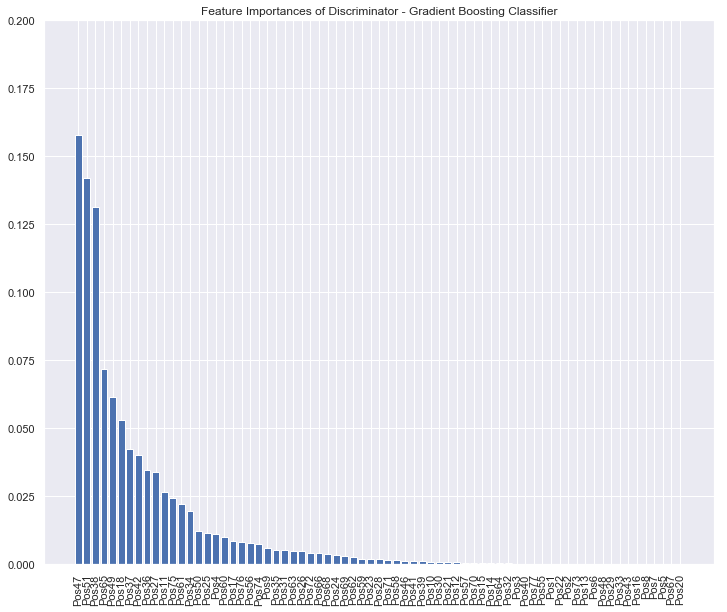

In [136]:
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_model.columns[i] for i in indices]

plt.figure(figsize=(12,10))
plt.title("Feature Importances of Discriminator - Gradient Boosting Classifier")
plt.bar(range(X_model.shape[1]), importances[indices])
plt.xticks(range(X_model.shape[1]), names, rotation=90)
plt.ylim(0, 0.20)
#plt.savefig(path.join(figpath, "Feature Importances of Discriminator - Gradient Boosting Classifier.pdf"))
#plt.close()
plt.show()

Out of 77 positions (71 after multicollinearity), 3 positions (Pos47, Pos51 and Pos38) are crucial to discriminate between generated synthetic toxibs and real 93 toxins.

In [154]:
generated_seqs = synthetic_seqs.Sequence

chars_gen_seqs = []
for seq in generated_seqs:
    chars_gen_seq = split(seq)
    chars_gen_seqs.append(chars_gen_seq)
    
X_chars_gen_seqs = pd.DataFrame(chars_gen_seqs, columns = col_names, index=generated_seqs.index)

X_chars_gen_seqs[['Pos47', 'Pos51', 'Pos38']].head(100)

Pos47 Pos51 Pos38
btoxin.54      G     S     -
btoxin.594     A     A     Q
btoxin.245     T     A     -
btoxin.886     A     G     Q
btoxin.863     A     G     Q
btoxin.232     F     S     G
btoxin.684     A     G     -
btoxin.731     G     S     Q
btoxin.175     G     G     -
btoxin.77      F     G     Q
btoxin.137     G     S     Q
btoxin.958     G     S     G
btoxin.698     F     S     -
btoxin.144     A     A     -
btoxin.507     T     A     -
btoxin.689     S     A     G
btoxin.88      G     A     -
btoxin.348     T     S     Q
btoxin.717     G     A     Q
btoxin.258     T     G     Q
btoxin.79      T     G     Q
btoxin.371     S     S     Q
btoxin.362     T     G     Q
btoxin.403     S     A     G
btoxin.909     G     A     Q
btoxin.493     T     A     Q
btoxin.791     S     G     Q
btoxin.504     F     S     G
btoxin.241     A     G     -
btoxin.806     T     S     Q
...          ...   ...   ...
btoxin.78      T     S     Q
btoxin.298     S     A     Q
btoxin.196     G     A     Q
btoxin.165     F     S     Q
btoxin.821     F     G     -
btoxin.489     S     A     Q
btoxin.697     G     A     -
btoxin.501     S     G     Q
btoxin.857     F     G     G
btoxin.986     T     S     Q
btoxin.193     A     A     G
btoxin.25      S     A     Q
btoxin.769     T     G     G
btoxin.21      G     G     G
btoxin.90      F     S     -
btoxin.838     F     S     Q
btoxin.113     G     G     G
btoxin.563     G     S     -
btoxin.365     G     S     G
btoxin.848     T     G     -
btoxin.271     G     A     G
btoxin.425     T     S     G
btoxin.927     F     S     G
btoxin.337     S     A     -
btoxin.130     G     S     -
btoxin.445     A     G     G
btoxin.931     T     G     G
btoxin.133     A     S     Q
btoxin.528     F     S     -
btoxin.411     F     G     -

[100 rows x 3 columns]

In [153]:
chars_df[['Pos47', 'Pos51', 'Pos38']]

Pos47 Pos51 Pos38
Q4LCS8     D     Q     -
P58752     A     K     -
P0C1B7     A     E     -
P0C1B5     A     F     -
P0C1B6     A     S     -
Q8WRY4     S     A     -
P0CH40     G     S     -
P01491     G     G     I
P15223     G     G     R
P58778     Q     N     Q
Q94435     K     A     Q
Q68PH4     A     A     Q
P01492     A     A     Q
P45667     S     A     Q
P01494     A     A     Q
P01493     A     A     Q
P45663     A     G     Q
B7FDP2     A     G     Q
F8UWP3     I     T     -
P60264     -     -     -
P01495     A     A     G
P80076     A     G     G
P18926     A     G     G
P0CH41     A     G     G
P45666     A     G     G
P59899     A     G     G
P59897     A     G     G
P59898     A     G     G
P08900     A     A     G
P45662     A     G     G
...      ...   ...   ...
Q9XY87     T     A     -
Q9BKJ1     T     A     -
P19855     T     A     -
Q26292     T     A     -
P68726     T     A     -
P55903     T     A     -
P55904     T     A     -
P84693     A     S     -
C9X4J9     A     A     -
P0CF39     A     A     -
P0C1X7     A     A     -
C9X4K1     A     A     -
Q1I180     L     A     -
P60215     A     A     -
C9X4J8     A     A     -
Q1I177     A     A     -
P84631     A     A     -
Q1I163     A     A     -
Q1I169     A     A     -
Q1I179     A     A     -
Q2NME3     A     A     -
Q1I174     A     A     -
P0CF37     A     A     -
F1CGT6     F     A     -
P60275     A     A     -
C0HJM9     A     A     -
P56609     A     A     -
P56612     A     A     -
P56611     A     A     -
P0DMM8     A     A     -

[93 rows x 3 columns]

So far, we note the absence of poorly represented amino acids (K,N,I,E,D,Q) from real toxins among generated toxins. One can suggest that there could be a long-distance association between the different amino acids. e.g. AA-, AAQ, AGG etc... To a certain degree, generating sequences using PSSMs takes into consideration these long-distance associations; we used the cumulative frequency as objective function where we selected the amino acids that are the most represented. If any association / long-distance relationships between these amino acids exist are these residues are well represented, they will be picked for the new generated sequences. To explore further the possible long-distance associations, we will generate new sequences using LSTM-RNNs.

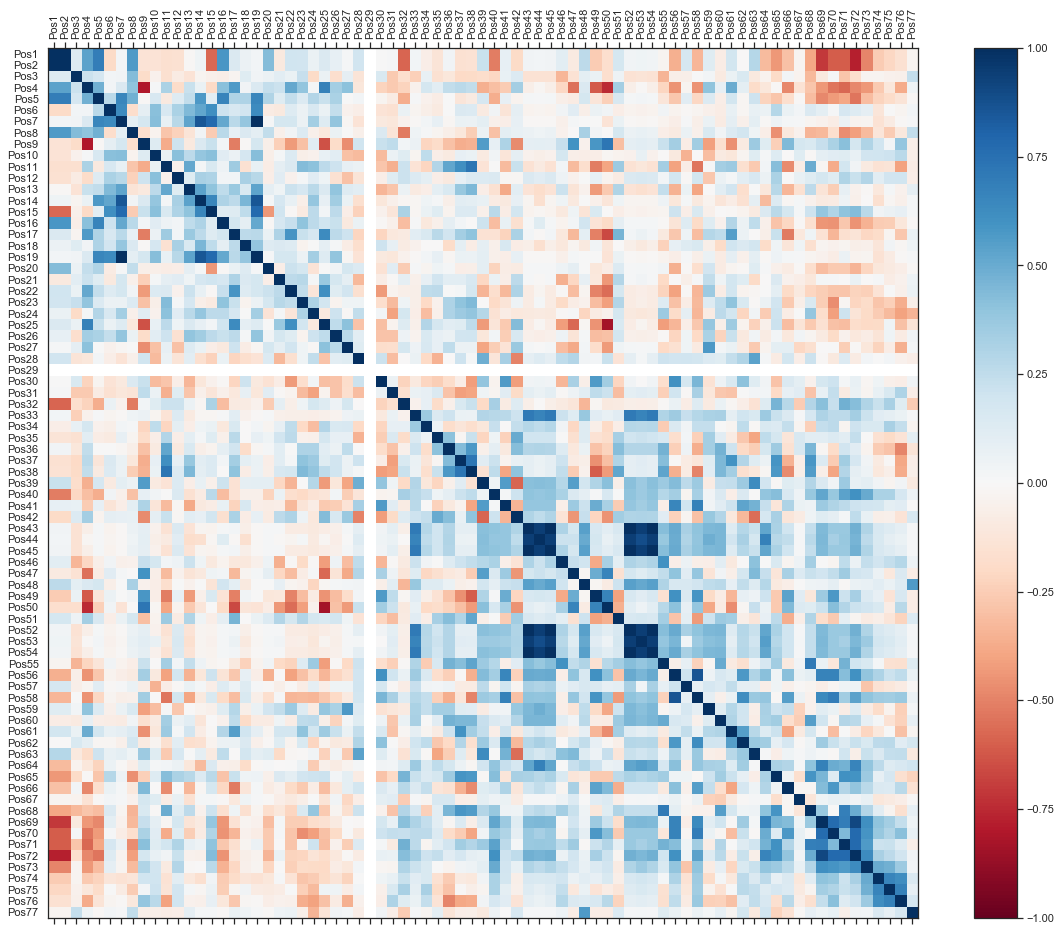

In [213]:
# Create correlation matrix
zappo_chars_df = Zappo_encoding(chars_df)
corr_matrix = zappo_chars_df.corr()

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111)
cax = ax.matshow(corr_matrix,cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(chars_df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(chars_df.columns)
ax.set_yticklabels(chars_df.columns)
plt.show()

In [214]:
# Create correlation matrix
zappo_gen_seqs = Zappo_encoding(X_chars_gen_seqs)
corr_matrix2 = zappo_gen_seqs .corr()

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111)
cax = ax.matshow(corr_matrix2,cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(zappo_gen_seqs.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(zappo_gen_seqs.columns)
ax.set_yticklabels(zappo_gen_seqs.columns)
plt.show()